# Implement Kalman model using FastAI

> need to implement custom data preparation pipeline and loss function 

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| default_exp kalman.fastai

In [ ]:
#| export
from meteo_imp.utils import *
from meteo_imp.gaussian import *
from meteo_imp.data import *

from fastcore.transform import *
from fastcore.basics import *
from fastcore.foundation import *
from fastcore.all import *
from fastai.tabular import *
from fastai.tabular.core import *
from fastai.data.core import *
from fastai.data import *
from fastai.torch_core import default_device, to_device
from dataclasses import dataclass

import torch

import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
reset_seed()

In [ ]:
hai_path

Path('/home/simone/Documents/uni/Thesis/GPFA_imputation/data/FLX_DE-Hai_FLUXNET2015_FULLSET_HH_2000-2012_1-4_float32.parquet')

In [ ]:
# hai = pd.read_parquet(hai_path)
hai = pd.read_parquet(hai_path64)
hai_era = pd.read_parquet(hai_era_path64)
# hai_era64 = pd.read_parquet(hai_era_path64)

## Data Preparation

The aim of the data preparation pipeline is to:
- take the original time series and split it into time blocks
- for each block generate a random gap (need to figure out the properties of the gap)
- split some time blocks for testing

the input of the pipeline is:
- a dataframe containing all observations

the input of the model is:
- observed data (potentially containing NaN where data is missing)
- missing data mask (which is telling where the data is missing)
- the data needs to be standardized

### Utils

In [ ]:
#| export
from dominate.tags import *

In [ ]:
#| export
@patch
def _repr_html_(self: Transform, as_str=True):
    with div() as out:
        p(strong(self.name))
        p(repr(self.encodes))
        p(repr(self.decodes))
    out = str(out) if as_str else out
    return out

In [ ]:
#| export
@patch
def _repr_html_(self: TfmdLists):
    with div() as out:
        span("TfmdLists. Items:")
        pre(coll_repr(self.items))
        ol([li(f._repr_html_(as_str=False)) for f in self.fs], start="0")
    return str(out)

### Item

In [ ]:
#| export
@dataclass
class MeteoImpItem:
    i: int # the number of the block to select
    shift: int # how much to shift the block
    var_sel: list[str] # variables where there is a gap
    gap_len: int # length of the gap
    def __post_init__(self): self.var_sel = listify(self.var_sel)
    def __iter__(self): return iter((self.i, self.shift, self.var_sel, self.gap_len))

In [ ]:
item = MeteoImpItem(2, 3, 'TA', 10)
item

MeteoImpItem(i=2, shift=3, var_sel=['TA'], gap_len=10)

### 1) Block Index

the first step is to transfrom the original dataframe into blocks of a specified `block_len`

two different strategies are possible:

- contigous blocks
- random block in the dataframe

for now contigous blocks are used

In [ ]:
#| export
@dataclass
class MeteoImpIndex:
    index: pd.DatetimeIndex # the number of the block to select
    var_sel: list[str] # variables where there is a gap
    gap_len: int # length of the gap
    def __post_init__(self): self.var_sel = listify(self.var_sel)

In [ ]:
#| export
class BlockIndexTransform(Transform):
    """divide timeseries DataFrame index into blocks"""
    def __init__(self, idx: pd.DatetimeIndex, block_len:int =200, offset=1):
        store_attr()
        self.n = len(idx)
        
    def encodes(self, item:MeteoImpItem
               ) -> MeteoImpIndex:       
        start = item.i * self.block_len + self.offset + item.shift
        end = (item.i+1) * self.block_len + self.offset + item.shift
        assert end <= self.n, f"Item index {item.i} too big for dataframe of length {self.n} with block len {self.block_len}"
        
        return MeteoImpIndex(self.idx[start:end], item.var_sel, item.gap_len)

In [ ]:
blk = BlockIndexTransform(hai.index, 10)

In [ ]:
blk

BlockIndexTransform:
encodes: (MeteoImpItem,object) -> encodes
decodes:

In [ ]:
blk(item)

MeteoImpIndex(index=DatetimeIndex(['2000-01-01 12:30:00', '2000-01-01 13:00:00',
               '2000-01-01 13:30:00', '2000-01-01 14:00:00',
               '2000-01-01 14:30:00', '2000-01-01 15:00:00',
               '2000-01-01 15:30:00', '2000-01-01 16:00:00',
               '2000-01-01 16:30:00', '2000-01-01 17:00:00'],
              dtype='datetime64[ns]', name='time', freq=None), var_sel=['TA'], gap_len=10)

### 2) Meteo Imp Block DataFrames

Get a chunck out of dataframes given an index

In [ ]:
#| export
@dataclass
class DataControl:
    data: pd.DataFrame
    control: pd.DataFrame
    var_sel: list[str]
    gap_len: int
    def _repr_html_(self):
            return row_dfs({'data': self.data, 'control': self.control}, title=f"Data Control ({self.var_sel}, {self.gap_len})", hide_idx=False)
    def __iter__(self): return iter((self.data, self.control, self.var_sel, self.gap_len))

In [ ]:
df = hai.loc[blk(item).index]

#### Add lag

In [ ]:
#| export
def _rename_lag(lag):
    def _inner(col_name):
        return f"{col_name}_lag_{lag}"
    return _inner

In [ ]:
df.rename(columns=_rename_lag(1))

,TA_lag_1,SW_IN_lag_1,VPD_lag_1
time,,,
2000-01-01 12:30:00,0.33,18.86,0.008
2000-01-01 13:00:00,0.41,21.10,0.006
2000-01-01 13:30:00,0.44,28.87,0.000
2000-01-01 14:00:00,0.48,24.22,0.000
2000-01-01 14:30:00,0.49,24.35,0.000
2000-01-01 15:00:00,0.51,15.68,0.000
2000-01-01 15:30:00,0.52,8.09,0.000
2000-01-01 16:00:00,0.57,6.37,0.000
2000-01-01 16:30:00,0.73,1.72,0.000


In [ ]:
#| export
def _lag_df(df, lag):
    "add lagged columns"
    df_lag = df.shift(lag).rename(columns = _rename_lag(lag))
    return df_lag
    

In [ ]:
_lag_df(df, 1)

,TA_lag_1,SW_IN_lag_1,VPD_lag_1
time,,,
2000-01-01 12:30:00,NaN,NaN,NaN
2000-01-01 13:00:00,0.33,18.86,0.008
2000-01-01 13:30:00,0.41,21.10,0.006
2000-01-01 14:00:00,0.44,28.87,0.000
2000-01-01 14:30:00,0.48,24.22,0.000
2000-01-01 15:00:00,0.49,24.35,0.000
2000-01-01 15:30:00,0.51,15.68,0.000
2000-01-01 16:00:00,0.52,8.09,0.000
2000-01-01 16:30:00,0.57,6.37,0.000


In [ ]:
#| export
def _add_lags_df(df, lags):
    df_lagged = df
    for lag in listify(lags):
        df_lagged = pd.merge(df_lagged, _lag_df(df, lag), left_index=True, right_index=True)
    return df_lagged

In [ ]:
_add_lags_df(df, [1,2])

,TA,SW_IN,VPD,TA_lag_1,SW_IN_lag_1,VPD_lag_1,TA_lag_2,SW_IN_lag_2,VPD_lag_2
time,,,,,,,,,
2000-01-01 12:30:00,0.33,18.86,0.008,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 13:00:00,0.41,21.10,0.006,0.33,18.86,0.008,NaN,NaN,NaN
2000-01-01 13:30:00,0.44,28.87,0.000,0.41,21.10,0.006,0.33,18.86,0.008
2000-01-01 14:00:00,0.48,24.22,0.000,0.44,28.87,0.000,0.41,21.10,0.006
2000-01-01 14:30:00,0.49,24.35,0.000,0.48,24.22,0.000,0.44,28.87,0.000
2000-01-01 15:00:00,0.51,15.68,0.000,0.49,24.35,0.000,0.48,24.22,0.000
2000-01-01 15:30:00,0.52,8.09,0.000,0.51,15.68,0.000,0.49,24.35,0.000
2000-01-01 16:00:00,0.57,6.37,0.000,0.52,8.09,0.000,0.51,15.68,0.000
2000-01-01 16:30:00,0.73,1.72,0.000,0.57,6.37,0.000,0.52,8.09,0.000


In [ ]:
#| export
class BlockDfTransform(Transform):
    """divide timeseries DataFrame index into blocks"""
    def __init__(self, data: pd.DataFrame, control: pd.DataFrame, control_lags: int|Iterable[int]):
        store_attr()
        self.control = _add_lags_df(control, control_lags)
    def encodes(self, idx: MeteoImpIndex) -> DataControl:
        return DataControl(self.data.loc[idx.index], self.control.loc[idx.index], idx.var_sel, idx.gap_len)

In [ ]:
blkdf = BlockDfTransform(hai, hai_era, 1)

In [ ]:
blkdf(blk(item))

,TA,SW_IN,VPD
time,,,
2000-01-01 12:30:00,0.3300,18.8600,0.0080
2000-01-01 13:00:00,0.4100,21.1000,0.0060
2000-01-01 13:30:00,0.4400,28.8700,0.0000
2000-01-01 14:00:00,0.4800,24.2200,0.0000
2000-01-01 14:30:00,0.4900,24.3500,0.0000
2000-01-01 15:00:00,0.5100,15.6800,0.0000
2000-01-01 15:30:00,0.5200,8.0900,0.0000
2000-01-01 16:00:00,0.5700,6.3700,0.0000
2000-01-01 16:30:00,0.7300,1.7200,0.0000


taking a day in the summer so there is an higher values for the variables

In [ ]:
blkdf(blk(MeteoImpItem(800,0, 'TA', 10))).data

,TA,SW_IN,VPD
time,,,
2000-06-15 17:00:00,14.22,224.80,5.799
2000-06-15 17:30:00,14.11,195.28,6.577
2000-06-15 18:00:00,14.23,244.17,6.931
2000-06-15 18:30:00,14.40,253.92,7.286
2000-06-15 19:00:00,14.09,177.31,7.251
2000-06-15 19:30:00,13.71,97.07,6.683
2000-06-15 20:00:00,13.08,39.71,5.851
2000-06-15 20:30:00,12.41,10.65,5.254
2000-06-15 21:00:00,12.27,0.32,5.164


In [ ]:
tfms1 = TfmdLists([MeteoImpItem(800+i,0, 'TA', 10) for i in range(3)], [BlockIndexTransform(hai.index, 10), BlockDfTransform(hai, hai_era, control_lags=1)])

In [ ]:
tfms1[0]

,TA,SW_IN,VPD
time,,,
2000-06-15 17:00:00,14.2200,224.8000,5.7990
2000-06-15 17:30:00,14.1100,195.2800,6.5770
2000-06-15 18:00:00,14.2300,244.1700,6.9310
2000-06-15 18:30:00,14.4000,253.9200,7.2860
2000-06-15 19:00:00,14.0900,177.3100,7.2510
2000-06-15 19:30:00,13.7100,97.0700,6.6830
2000-06-15 20:00:00,13.0800,39.7100,5.8510
2000-06-15 20:30:00,12.4100,10.6500,5.2540
2000-06-15 21:00:00,12.2700,0.3200,5.1640


### 3) Gaps

adds a mask which includes a random gap

#### Make random Gap

In [ ]:
idx = L(*tfms1[0].data.columns).argwhere(lambda x: x in ['TA','SW_IN'])

In [ ]:
mask = np.ones_like(tfms1[0].data, dtype=bool)

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
#| exports
def _make_random_gap(
    gap_length: int, # The length of the gap
    total_length: int, # The total number of observations
    gap_start: int # Optional start of gap
)-> np.ndarray: # [total_length] array of bools to indicicate if the data is missing or not
    "Add a continous gap of given length at random position"
    if(gap_length >= total_length):
        return np.repeat(True, total_length)
    return np.hstack([
        np.repeat(False, gap_start),
        np.repeat(True, gap_length),
        np.repeat(False, total_length - (gap_length + gap_start))
    ])

In [ ]:
gap = _make_random_gap(2, 10, 2)

In [ ]:
gap

array([False, False,  True,  True, False, False, False, False, False,
       False])

In [ ]:
np.argwhere(gap)

array([[2],
       [3]])

In [ ]:
mask[np.argwhere(gap), idx] = False

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [False, False,  True],
       [False, False,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
mask[gap]

array([[False, False,  True],
       [False, False,  True]])

#### Add Gap Transform

In [ ]:
#| export
@dataclass
class MeteoImpDf:
    data: pd.DataFrame
    mask: pd.DataFrame
    control: pd.DataFrame
    def __iter__(self): return iter((self.data, self.mask, self.control,))
    __repr__ = basic_repr("data, mask, control")
    def _repr_html_(self):
        return row_dfs({'data': self.data, 'mask': self.mask, 'control': self.control}, title="Meteo Imp Df", hide_idx=False)
    def copy(self):
        return MeteoImpDf(self.data.copy(), self.mask.copy(), self.control.copy())

In [ ]:
#| export
class AddGapTransform(Transform):
    """Adds a random gap to a dataframe"""
    def __init__(self,gap_start): store_attr()
    def encodes(self, dc: DataControl) -> MeteoImpDf:
        df, control, var_sel, gap_len = dc
        gap = _make_random_gap(gap_len, df.shape[0], self.gap_start)
        mask = np.ones_like(df, dtype=bool)
        col_sel = L(*df.columns).argwhere(lambda x: x in var_sel)
        mask[np.argwhere(gap), col_sel] = False
        mask = pd.DataFrame(mask, index=df.index, columns=df.columns)
        return MeteoImpDf(df, mask, control)

In [ ]:
a_gap = AddGapTransform(1)
a_gap

AddGapTransform:
encodes: (DataControl,object) -> encodes
decodes:

In [ ]:
a_gap(tfms1[0])

,TA,SW_IN,VPD
time,,,
2000-06-15 17:00:00,14.2200,224.8000,5.7990
2000-06-15 17:30:00,14.1100,195.2800,6.5770
2000-06-15 18:00:00,14.2300,244.1700,6.9310
2000-06-15 18:30:00,14.4000,253.9200,7.2860
2000-06-15 19:00:00,14.0900,177.3100,7.2510
2000-06-15 19:30:00,13.7100,97.0700,6.6830
2000-06-15 20:00:00,13.0800,39.7100,5.8510
2000-06-15 20:30:00,12.4100,10.6500,5.2540
2000-06-15 21:00:00,12.2700,0.3200,5.1640


In [ ]:
tfms2 = TfmdLists(tfms1.items, [*tfms1.fs, AddGapTransform(5)])

##### Tidy

In [ ]:
m_df = a_gap(tfms1[0])

In [ ]:
#| export
@patch
def tidy(self: MeteoImpDf,
         control_map:Optional[dict[str, str]] = None # mapping from control var names to obs names
        ):
    data = self.data.reset_index().melt("time")
    mask = self.mask.reset_index().melt("time", value_name="is_present")
    
    if control_map is not None:
        control = (self.control[control_map.keys()].rename(columns=control_map)
                    .reset_index().melt("time", value_name="control"))
        data = pd.merge(data, control, on=["time", "variable"], how="left")
    
    return pd.merge(data, mask, on=["time", "variable"])

In [ ]:
#| export
hai_control = {'TA_ERA': 'TA', 'SW_IN_ERA': 'SW_IN', 'VPD_ERA': 'VPD'}

In [ ]:
m_df.tidy()

,time,variable,value,is_present
0,2000-06-15 17:00:00,TA,14.220,False
1,2000-06-15 17:30:00,TA,14.110,False
2,2000-06-15 18:00:00,TA,14.230,False
3,2000-06-15 18:30:00,TA,14.400,False
4,2000-06-15 19:00:00,TA,14.090,False
5,2000-06-15 19:30:00,TA,13.710,False
6,2000-06-15 20:00:00,TA,13.080,False
7,2000-06-15 20:30:00,TA,12.410,False
8,2000-06-15 21:00:00,TA,12.270,False
9,2000-06-15 21:30:00,TA,12.200,False


In [ ]:
m_df.tidy(control_map={'TA_ERA': 'TA'})

,time,variable,value,control,is_present
0,2000-06-15 17:00:00,TA,14.220,15.050,False
1,2000-06-15 17:30:00,TA,14.110,14.961,False
2,2000-06-15 18:00:00,TA,14.230,14.872,False
3,2000-06-15 18:30:00,TA,14.400,14.783,False
4,2000-06-15 19:00:00,TA,14.090,14.694,False
5,2000-06-15 19:30:00,TA,13.710,14.606,False
6,2000-06-15 20:00:00,TA,13.080,14.380,False
7,2000-06-15 20:30:00,TA,12.410,14.155,False
8,2000-06-15 21:00:00,TA,12.270,13.929,False
9,2000-06-15 21:30:00,TA,12.200,13.704,False


In [ ]:
m_df.tidy(control_map=hai_control).head()

,time,variable,value,control,is_present
0,2000-06-15 17:00:00,TA,14.22,15.050,False
1,2000-06-15 17:30:00,TA,14.11,14.961,False
2,2000-06-15 18:00:00,TA,14.23,14.872,False
3,2000-06-15 18:30:00,TA,14.40,14.783,False
4,2000-06-15 19:00:00,TA,14.09,14.694,False


#### Plotting

In [ ]:
#| export
import altair as alt
from altair import datum

In [ ]:
#| exporti
def def_selection():
    return alt.selection_interval(bind="scales")

##### Rug

In [ ]:
#| exporti
def plot_rug(df, sel = def_selection(), props = {}):
    if 'height' in props:
        props = props.copy() 
        props.pop('height') # rug should have default heigth
    return alt.Chart(df).mark_tick(
            color='black',
        ).encode(
            x = "time",
            color = alt.condition(datum.is_present, alt.value('white'), alt.value('black'))
        ).add_params(
            sel
        ).properties(**props) 

In [ ]:
plot_rug(m_df.tidy())

alt.Chart(...)

In [ ]:
df = m_df.tidy()

In [ ]:
df = df[df.variable=="TA"].copy()

In [ ]:
df['row_number'] = df.reset_index().index

In [ ]:
df

,time,variable,value,is_present,row_number
0,2000-06-15 17:00:00,TA,14.22,False,0
1,2000-06-15 17:30:00,TA,14.11,False,1
2,2000-06-15 18:00:00,TA,14.23,False,2
3,2000-06-15 18:30:00,TA,14.40,False,3
4,2000-06-15 19:00:00,TA,14.09,False,4
5,2000-06-15 19:30:00,TA,13.71,False,5
6,2000-06-15 20:00:00,TA,13.08,False,6
7,2000-06-15 20:30:00,TA,12.41,False,7
8,2000-06-15 21:00:00,TA,12.27,False,8
9,2000-06-15 21:30:00,TA,12.20,False,9


In [ ]:
df.iloc[1]

time          2000-06-15 17:30:00
variable                       TA
value                       14.11
is_present                  False
row_number                      1
Name: 1, dtype: object

In [ ]:
df.loc[2, "is_present"] = True

In [ ]:
df

,time,variable,value,is_present,row_number
0,2000-06-15 17:00:00,TA,14.22,False,0
1,2000-06-15 17:30:00,TA,14.11,False,1
2,2000-06-15 18:00:00,TA,14.23,True,2
3,2000-06-15 18:30:00,TA,14.40,False,3
4,2000-06-15 19:00:00,TA,14.09,False,4
5,2000-06-15 19:30:00,TA,13.71,False,5
6,2000-06-15 20:00:00,TA,13.08,False,6
7,2000-06-15 20:30:00,TA,12.41,False,7
8,2000-06-15 21:00:00,TA,12.27,False,8
9,2000-06-15 21:30:00,TA,12.20,False,9


In [ ]:
i = 1
prev, curr, _next= df.iloc[i-1], df.iloc[i], df.iloc[i+1]

In [ ]:
prev, curr, _next

(time          2000-06-15 17:00:00
 variable                       TA
 value                       14.22
 is_present                  False
 row_number                      0
 Name: 0, dtype: object,
 time          2000-06-15 17:30:00
 variable                       TA
 value                       14.11
 is_present                  False
 row_number                      1
 Name: 1, dtype: object,
 time          2000-06-15 18:00:00
 variable                       TA
 value                       14.23
 is_present                   True
 row_number                      2
 Name: 2, dtype: object)

In [ ]:
df

,time,variable,value,is_present,row_number
0,2000-06-15 17:00:00,TA,14.22,False,0
1,2000-06-15 17:30:00,TA,14.11,False,1
2,2000-06-15 18:00:00,TA,14.23,True,2
3,2000-06-15 18:30:00,TA,14.40,False,3
4,2000-06-15 19:00:00,TA,14.09,False,4
5,2000-06-15 19:30:00,TA,13.71,False,5
6,2000-06-15 20:00:00,TA,13.08,False,6
7,2000-06-15 20:30:00,TA,12.41,False,7
8,2000-06-15 21:00:00,TA,12.27,False,8
9,2000-06-15 21:30:00,TA,12.20,False,9


In [ ]:
for i in range(len(df)):
    # handle boundaries
    prev = df.iloc[i-1].is_present if i>0 else True 
    _next = df.iloc[i+1].is_present if i<(len(df)-1) else True 
    curr = df.iloc[i]
    if not curr.is_present and prev:
        print("gap start", curr.time)
    if not curr.is_present and _next:
        print("gap end", curr.time)

gap start 2000-06-15 17:00:00
gap end 2000-06-15 17:30:00
gap start 2000-06-15 18:30:00
gap end 2000-06-15 21:30:00


In [ ]:
#| export
def find_gap_limits(df):
    gap_starts, gap_ends = [], []
    for i in range(len(df)):
        prev = df.iloc[i-1].is_present if i>0 else True 
        _next = df.iloc[i+1].is_present if i<(len(df)-1) else True 
        curr = df.iloc[i]
        if not curr.is_present and prev: gap_starts.append(curr.time)
        if not curr.is_present and _next: gap_ends.append(curr.time)
    return pd.DataFrame({'gap_start': gap_starts, 'gap_end': gap_ends})
    

In [ ]:
find_gap_limits(df)

,gap_start,gap_end
0,2000-06-15 17:00:00,2000-06-15 17:30:00
1,2000-06-15 18:30:00,2000-06-15 21:30:00


In [ ]:
#| export
def plot_missing_area(df, sel = def_selection(), props={}):
    gap_limits = find_gap_limits(df)
    start = alt.Chart(gap_limits).mark_rule().encode(
        x = alt.X('gap_start', axis=alt.Axis(domain=False, labels = False, ticks=False, title=None)),
    )
    end = alt.Chart(gap_limits).mark_rule().encode(
        x = alt.X('gap_end', axis=alt.Axis(domain=False, labels = False, ticks=False, title=None))
    )
    area = alt.Chart(gap_limits).mark_rect(color='black', opacity=.15).encode(
        x = alt.X('gap_start', axis=alt.Axis(domain=False, labels = False, ticks=False, title=None)),
        x2 = 'gap_end'
    )
    return (start + end + area)#.add_params(sel).properties(**props)

In [ ]:
plot_missing_area(df)

alt.LayerChart(...)

##### Points

In [ ]:
#| export
def plot_points(df, y = "value", y_label = "", sel = def_selection(), props = {}):
    return alt.Chart(df).mark_point(
            color='black',
            strokeWidth = 1,
            fillOpacity = 1,
            # size = 35,
        ).encode(
            x = alt.X("time", axis=alt.Axis(domain=True, labels = True, ticks=True, title="time")),
            y = alt.Y(y, title = y_label, scale=alt.Scale(zero=False)),
            fill= alt.Fill("is_present", scale = alt.Scale(range=["#ffffff00", "gray"]),
                           legend = alt.Legend(title =["Observed data"])),
            shape = alt.Shape("is_present", scale= alt.Scale(range=["square", "circle"])),
        )

In [ ]:
plot_points(m_df.tidy())

alt.Chart(...)

##### Line

In [ ]:
#| exporti
def plot_line(df, only_present=True, y="value", y_label = "", sel = def_selection(), props = {}):
    # df = df[df.is_present] if only_present else df
    # TODO remove onle_present
    return alt.Chart(df).mark_line().encode(
        x = "time",    
        y = alt.Y(y, title = y_label, scale=alt.Scale(zero=False)),
        color=alt.Color('variable', scale= scale_meteo)
    ).add_params(
        sel
    ).properties(
        **props
    )#.transform_filter(
    #     datum.is_present
    # )

    

In [ ]:
plot_line(m_df.tidy())

alt.Chart(...)

##### Control

In [ ]:
#| exporti
def plot_control(df, only_present=True, y="control", y_label = "", sel = def_selection(), props = {}):
    # df = df[df.is_present] if only_present else df
    # TODO remove onle_present
    return alt.Chart(df).mark_line(strokeDash=[4,6], color="purple").encode(
        x = "time",    
        y = alt.Y(y, title = y_label, scale=alt.Scale(zero=False)),
    ).add_params(
        sel
    ).properties(
        **props
    )    

In [ ]:
plot_control(m_df.tidy(), y="value")

alt.Chart(...)

##### Errorband

In [ ]:
#| exporti
def plot_error(df, y = "value", y_label = "", sel = def_selection(), props = {}):
    df.loc[:,'err_low'] = df[y] - 2 * df['std']
    df.loc[:,'err_high'] = df[y] + 2 * df['std']
    return alt.Chart(df).mark_errorband().encode(
        x = "time",    
        y = alt.Y("err_low:Q", title = y_label, scale=alt.Scale(zero=False)),
        y2 = "err_high:Q",
        color=alt.Color("variable",
                        legend = alt.Legend(title=["Line: pred. mean", "area: +/- 2 std"]),
                        scale = scale_meteo
                       )
    ).add_params(
        sel
    ).properties(
        **props
    )
    

In [ ]:
plot_error(m_df.tidy().assign(std=5))

alt.Chart(...)

##### Variable

In [ ]:
#| export
def plot_variable(df,
                  variable, ys=["value", "value", "control"],
                  title="",
                  y_label="",
                  sel = None,
                  error=False,
                  point=True,
                  gap_area = True,
                  control=False,
                  props = {}):
    df = df[df.variable == variable].copy()
    sel = ifnone(sel, def_selection())
    # rug = plot_rug(df, sel, props)
    plots = []
    if point: plots.append(plot_points(df, ys[0], y_label, sel, props))
    if gap_area and not df.is_present.all():
        plots.append(plot_missing_area(df, sel, props)) # there is a gap
    if error: plots.append(plot_error(df, y=ys[1], y_label=y_label, sel=sel, props=props))
    if control: plots.append(plot_control(df, y=ys[2], y_label=y_label, sel=sel, props=props))
    plots.append(plot_line(df, True, ys[1], y_label, sel, props))
    
    return alt.layer(*plots).properties(title=title)
    
    # return alt.VConcatChart(vconcat=[(points + line), rug], spacing=-10).properties(title=title)

In [ ]:
plot_variable(m_df.tidy(), "TA", title="title TA")

alt.LayerChart(...)

In [ ]:
plot_variable(m_df.tidy(control_map=hai_control), "TA", title="title TA", control=True)

alt.LayerChart(...)

In [ ]:
plot_variable(m_df.tidy().assign(std=.5), "TA", title="title TA", error=True)

alt.LayerChart(...)

In [ ]:
plot_variable(m_df.tidy().assign(std=.5), "TA", title="title TA", error=True, point=False, gap_area=False)

alt.LayerChart(...)

##### Facet

In [ ]:
#| export
@delegates(plot_variable, but="y_label")
def facet_variable(df, # tidy dataframe
                   n_cols: int = 3,
                   bind_interaction: bool =True, # Whether the sub-plots for each variable should be connected for zooming/panning
                   units = None,
                    **kwargs
                   ) -> alt.Chart:
    """Plot all values of the column `variable` in different subplots"""
    kwargs['props'] = ifnone(kwargs.get('props', None), {'width': 200, 'height': 150})
    vars = df.variable.unique()
    plot_list = [alt.hconcat() for _ in range(0, len(vars), n_cols)]
    selection_scale = alt.selection_interval(bind="scales", encodings=['x']) if bind_interaction else None
    for idx, variable in enumerate(vars):
        y_label =  kwargs.get("y_label", f"{variable} [{units[variable]}]" if units is not None else variable)
        plot = plot_variable(df,
                            variable,
                            sel = selection_scale,
                            y_label = y_label, 
                            **kwargs)
        
        plot_list[idx // n_cols] |= plot
    
    plot = alt.vconcat(*plot_list)
    
    return plot

##### Show

In [ ]:
#| export
@patch
def show(self: MeteoImpDf, ax=None, ctx=None, 
        n_cols: int = 3,
        bind_interaction: bool =True, # Whether the sub-plots for each variable should be connected for zooming/panning
        props:dict = None # additional properties (eg. size) for altair plot
       ) -> alt.Chart:
    
    df = self.tidy()
    return facet_variable(df, n_cols, bind_interaction, props=props)

In [ ]:
m_df.show(bind_interaction = False)

alt.VConcatChart(...)

In [ ]:
tfms2[0].show()

alt.VConcatChart(...)

In [ ]:
tfms2[2].show()

alt.VConcatChart(...)

### 4) To Tensor

this needs to handle both the init with a list of items and when the first item is a sequence of list of items

In [ ]:
#| export
class MeteoImpTensor(collections.abc.Sequence):
    def __init__(self,*args):
        if len(args)==3:
            self.data = args[0]
            self.mask = args[1]
            self.control = args[2]
        elif len(args)==1 and len(args[0])==2:
            self.data = args[0][0]
            self.mask = args[0][1]
            self.control = args[0][2]
        else:
            raise ValueError(f"Incorrect number of arguments. got {len(args)} args")

    def __iter__(self): return iter((self.data, self.mask,self.control))
    __len__ = 3
    def __getitem__(self, key):
        if key == 0: return self.data
        elif key == 1: return self.mask
        elif key == 2: return self.control
        else: raise IndexError("index bigger than 2")
    __repr__ = basic_repr('data, mask, control')
    def _repr_html_(self):
        return row_items(data = self.data, mask = self.mask, control = self.control)

In [ ]:
#| export
class MeteoImpDf2Tensor(Transform):
    def setups(self, items):
        self.columns = list(items[0].data.columns)
    def encodes(self, df: MeteoImpDf) -> MeteoImpTensor:
        data = torch.tensor(df.data.to_numpy())
        mask = torch.tensor(df.mask.to_numpy())
        control = torch.tensor(df.control.to_numpy())
        return MeteoImpTensor(data, mask, control)
        
    # def decodes(self, x: MeteoImpTensor) -> MeteoImpDf:
    #     data = pd.DataFrame(x.data.detach().cpu().numpy(), columns = self.columns)
    #     mask = pd.DataFrame(x.mask.cpu().numpy(), columns = self.columns)
    #     control = pd.DataFrame(x.control.cpu().numpy(), columns = self.columns)
    #     return MeteoImpDf(data, mask, control)

In [ ]:
to_t = MeteoImpDf2Tensor()

In [ ]:
to_t.setup(tfms2)

In [ ]:
to_t(tfms2[0])

__main__.MeteoImpTensor(data=tensor([[ 14.2200, 224.8000,   5.7990],
        [ 14.1100, 195.2800,   6.5770],
        [ 14.2300, 244.1700,   6.9310],
        [ 14.4000, 253.9200,   7.2860],
        [ 14.0900, 177.3100,   7.2510],
        [ 13.7100,  97.0700,   6.6830],
        [ 13.0800,  39.7100,   5.8510],
        [ 12.4100,  10.6500,   5.2540],
        [ 12.2700,   0.3200,   5.1640],
        [ 12.2000,   0.0000,   5.0370]], dtype=torch.float64), mask=tensor([[False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True]]), control=tensor([[ 15.0500, 255.1930,   5.1020,  15.1390, 287.1000,   4.9000],
        [ 14.9610, 221.4270,   5.3050,  15.0500, 255.1930,   5.1020],
        [ 14.8720, 186.3800,   5.5070,  14.9610, 221.4270,   5.3050],
        [ 14.7830, 150.6500,   5.7100,  14.8720, 186.3800,   5.5070],
        [ 14.6940, 114.8490,   5.9120,  14.7830, 150.6500,   5.7100],
        [ 14.6060,  34.7280,   6.1140,  14.6940, 114.8490,   5.9120],
        [ 14.3800,  19.8430,   6.0740,  14.6060,  34.7280,   6.1140],
        [ 14.1550,   5.7120,   6.0340,  14.3800,  19.8430,   6.0740],
        [ 13.9290,   0.0000,   5.9940,  14.1550,   5.7120,   6.0340],
        [ 13.7040,   0.0000,   5.9540,  13.9290,   0.0000,   5.9940]],
       dtype=torch.float64))

In [ ]:
to_t.decode(to_t(tfms2[0]));

In [ ]:
tfms2[0]

,TA,SW_IN,VPD
time,,,
2000-06-15 17:00:00,14.2200,224.8000,5.7990
2000-06-15 17:30:00,14.1100,195.2800,6.5770
2000-06-15 18:00:00,14.2300,244.1700,6.9310
2000-06-15 18:30:00,14.4000,253.9200,7.2860
2000-06-15 19:00:00,14.0900,177.3100,7.2510
2000-06-15 19:30:00,13.7100,97.0700,6.6830
2000-06-15 20:00:00,13.0800,39.7100,5.8510
2000-06-15 20:30:00,12.4100,10.6500,5.2540
2000-06-15 21:00:00,12.2700,0.3200,5.1640


In [ ]:
tfms3 = TfmdLists(tfms1.items, [*tfms2.fs, MeteoImpDf2Tensor()])

In [ ]:
tfms3[0]

__main__.MeteoImpTensor(data=tensor([[ 14.2200, 224.8000,   5.7990],
        [ 14.1100, 195.2800,   6.5770],
        [ 14.2300, 244.1700,   6.9310],
        [ 14.4000, 253.9200,   7.2860],
        [ 14.0900, 177.3100,   7.2510],
        [ 13.7100,  97.0700,   6.6830],
        [ 13.0800,  39.7100,   5.8510],
        [ 12.4100,  10.6500,   5.2540],
        [ 12.2700,   0.3200,   5.1640],
        [ 12.2000,   0.0000,   5.0370]], dtype=torch.float64), mask=tensor([[False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True]]), control=tensor([[ 15.0500, 255.1930,   5.1020,  15.1390, 287.1000,   4.9000],
        [ 14.9610, 221.4270,   5.3050,  15.0500, 255.1930,   5.1020],
        [ 14.8720, 186.3800,   5.5070,  14.9610, 221.4270,   5.3050],
        [ 14.7830, 150.6500,   5.7100,  14.8720, 186.3800,   5.5070],
        [ 14.6940, 114.8490,   5.9120,  14.7830, 150.6500,   5.7100],
        [ 14.6060,  34.7280,   6.1140,  14.6940, 114.8490,   5.9120],
        [ 14.3800,  19.8430,   6.0740,  14.6060,  34.7280,   6.1140],
        [ 14.1550,   5.7120,   6.0340,  14.3800,  19.8430,   6.0740],
        [ 13.9290,   0.0000,   5.9940,  14.1550,   5.7120,   6.0340],
        [ 13.7040,   0.0000,   5.9540,  13.9290,   0.0000,   5.9940]],
       dtype=torch.float64))

In [ ]:
type(tfms3[0])

__main__.MeteoImpTensor

### 5) Normalize

In [ ]:
#| export
from meteo_imp.utils import *
from fastai.torch_core import to_cpu

from torch import Tensor

In [ ]:
#| export
def get_stats(df, repeat=1, device='cpu'):
    return torch.tensor(df.mean(axis=0).to_numpy(), device=device).repeat(repeat), torch.tensor(df.std(axis=0).to_numpy(), device=device).repeat(repeat)

In [ ]:
#| export
class MeteoImpNormalize(Transform):
    "Normalize/denorm MeteoImpTensor column-wise "
    @property
    def name(self): return f"{super().name} -- {getattr(self,'__stored_args__',{})}"

    def __init__(self, mean_data, std_data, mean_control, std_control): store_attr()

    def encodes(self, x:MeteoImpTensor)-> MeteoImpTensor:
        return MeteoImpTensor((x.data - self.mean_data) / self.std_data, x.mask, (x.control - self.mean_control)/self.std_control)
    def decodes(self, x:MeteoImpTensor)->MeteoImpTensor:
        f = partial(to_device, device=(x[0].device))
        return MeteoImpTensor(x.data * f(self.std_data) + f(self.mean_data), x.mask, x.control * f(self.std_control) + f(self.mean_control))

In [ ]:
norm = MeteoImpNormalize(*get_stats(hai), *get_stats(hai_era,2))

In [ ]:
tfms3[0]

__main__.MeteoImpTensor(data=tensor([[ 14.2200, 224.8000,   5.7990],
        [ 14.1100, 195.2800,   6.5770],
        [ 14.2300, 244.1700,   6.9310],
        [ 14.4000, 253.9200,   7.2860],
        [ 14.0900, 177.3100,   7.2510],
        [ 13.7100,  97.0700,   6.6830],
        [ 13.0800,  39.7100,   5.8510],
        [ 12.4100,  10.6500,   5.2540],
        [ 12.2700,   0.3200,   5.1640],
        [ 12.2000,   0.0000,   5.0370]], dtype=torch.float64), mask=tensor([[False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True]]), control=tensor([[ 15.0500, 255.1930,   5.1020,  15.1390, 287.1000,   4.9000],
        [ 14.9610, 221.4270,   5.3050,  15.0500, 255.1930,   5.1020],
        [ 14.8720, 186.3800,   5.5070,  14.9610, 221.4270,   5.3050],
        [ 14.7830, 150.6500,   5.7100,  14.8720, 186.3800,   5.5070],
        [ 14.6940, 114.8490,   5.9120,  14.7830, 150.6500,   5.7100],
        [ 14.6060,  34.7280,   6.1140,  14.6940, 114.8490,   5.9120],
        [ 14.3800,  19.8430,   6.0740,  14.6060,  34.7280,   6.1140],
        [ 14.1550,   5.7120,   6.0340,  14.3800,  19.8430,   6.0740],
        [ 13.9290,   0.0000,   5.9940,  14.1550,   5.7120,   6.0340],
        [ 13.7040,   0.0000,   5.9540,  13.9290,   0.0000,   5.9940]],
       dtype=torch.float64))

In [ ]:
norm

MeteoImpNormalize -- {'mean_data': tensor([  8.3339, 120.9578,   3.3807], dtype=torch.float64), 'std_data': tensor([  7.9246, 204.0026,   4.3684], dtype=torch.float64), 'mean_control': tensor([  8.1948, 120.6864,   3.3253,   8.1948, 120.6864,   3.3253],
       dtype=torch.float64), 'std_control': tensor([  7.5459, 187.1730,   3.6871,   7.5459, 187.1730,   3.6871],
       dtype=torch.float64)}:
encodes: (MeteoImpTensor,object) -> encodes
decodes: (MeteoImpTensor,object) -> decodes

In [ ]:
norm(tfms3[0])

__main__.MeteoImpTensor(data=tensor([[ 0.7428,  0.5090,  0.5536],
        [ 0.7289,  0.3643,  0.7317],
        [ 0.7440,  0.6040,  0.8127],
        [ 0.7655,  0.6518,  0.8940],
        [ 0.7264,  0.2762,  0.8860],
        [ 0.6784, -0.1171,  0.7560],
        [ 0.5989, -0.3983,  0.5655],
        [ 0.5144, -0.5407,  0.4288],
        [ 0.4967, -0.5914,  0.4082],
        [ 0.4879, -0.5929,  0.3792]], dtype=torch.float64), mask=tensor([[False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True]]), control=tensor([[ 0.9085,  0.7186,  0.4819,  0.9203,  0.8891,  0.4271],
        [ 0.8967,  0.5382,  0.5369,  0.9085,  0.7186,  0.4819],
        [ 0.8849,  0.3510,  0.5917,  0.8967,  0.5382,  0.5369],
        [ 0.8731,  0.1601,  0.6468,  0.8849,  0.3510,  0.5917],
        [ 0.8613, -0.0312,  0.7015,  0.8731,  0.1601,  0.6468],
        [ 0.8496, -0.4592,  0.7563,  0.8613, -0.0312,  0.7015],
        [ 0.8197, -0.5388,  0.7455,  0.8496, -0.4592,  0.7563],
        [ 0.7899, -0.6143,  0.7346,  0.8197, -0.5388,  0.7455],
        [ 0.7599, -0.6448,  0.7238,  0.7899, -0.6143,  0.7346],
        [ 0.7301, -0.6448,  0.7129,  0.7599, -0.6448,  0.7238]],
       dtype=torch.float64))

In [ ]:
test_close(norm.decode(norm(tfms3[0]))[0], tfms3[0][0], eps=2e-5)

Test that NormalsParams decode actually works

In [ ]:
tfms4 = TfmdLists(tfms3.items, [*tfms3.fs,MeteoImpNormalize(*get_stats(hai),*get_stats(hai_era, 2) ) ])

In [ ]:
tfms4[0]

__main__.MeteoImpTensor(data=tensor([[ 0.7428,  0.5090,  0.5536],
        [ 0.7289,  0.3643,  0.7317],
        [ 0.7440,  0.6040,  0.8127],
        [ 0.7655,  0.6518,  0.8940],
        [ 0.7264,  0.2762,  0.8860],
        [ 0.6784, -0.1171,  0.7560],
        [ 0.5989, -0.3983,  0.5655],
        [ 0.5144, -0.5407,  0.4288],
        [ 0.4967, -0.5914,  0.4082],
        [ 0.4879, -0.5929,  0.3792]], dtype=torch.float64), mask=tensor([[False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True]]), control=tensor([[ 0.9085,  0.7186,  0.4819,  0.9203,  0.8891,  0.4271],
        [ 0.8967,  0.5382,  0.5369,  0.9085,  0.7186,  0.4819],
        [ 0.8849,  0.3510,  0.5917,  0.8967,  0.5382,  0.5369],
        [ 0.8731,  0.1601,  0.6468,  0.8849,  0.3510,  0.5917],
        [ 0.8613, -0.0312,  0.7015,  0.8731,  0.1601,  0.6468],
        [ 0.8496, -0.4592,  0.7563,  0.8613, -0.0312,  0.7015],
        [ 0.8197, -0.5388,  0.7455,  0.8496, -0.4592,  0.7563],
        [ 0.7899, -0.6143,  0.7346,  0.8197, -0.5388,  0.7455],
        [ 0.7599, -0.6448,  0.7238,  0.7899, -0.6143,  0.7346],
        [ 0.7301, -0.6448,  0.7129,  0.7599, -0.6448,  0.7238]],
       dtype=torch.float64))

In [ ]:
tfms4.decode(tfms4[0])

__main__.MeteoImpTensor(data=tensor([[1.4220e+01, 2.2480e+02, 5.7990e+00],
        [1.4110e+01, 1.9528e+02, 6.5770e+00],
        [1.4230e+01, 2.4417e+02, 6.9310e+00],
        [1.4400e+01, 2.5392e+02, 7.2860e+00],
        [1.4090e+01, 1.7731e+02, 7.2510e+00],
        [1.3710e+01, 9.7070e+01, 6.6830e+00],
        [1.3080e+01, 3.9710e+01, 5.8510e+00],
        [1.2410e+01, 1.0650e+01, 5.2540e+00],
        [1.2270e+01, 3.2000e-01, 5.1640e+00],
        [1.2200e+01, 1.4211e-14, 5.0370e+00]], dtype=torch.float64), mask=tensor([[False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True]]), control=tensor([[ 15.0500, 255.1930,   5.1020,  15.1390, 287.1000,   4.9000],
        [ 14.9610, 221.4270,   5.3050,  15.0500, 255.1930,   5.1020],
        [ 14.8720, 186.3800,   5.5070,  14.9610, 221.4270,   5.3050],
        [ 14.7830, 150.6500,   5.7100,  14.8720, 186.3800,   5.5070],
        [ 14.6940, 114.8490,   5.9120,  14.7830, 150.6500,   5.7100],
        [ 14.6060,  34.7280,   6.1140,  14.6940, 114.8490,   5.9120],
        [ 14.3800,  19.8430,   6.0740,  14.6060,  34.7280,   6.1140],
        [ 14.1550,   5.7120,   6.0340,  14.3800,  19.8430,   6.0740],
        [ 13.9290,   0.0000,   5.9940,  14.1550,   5.7120,   6.0340],
        [ 13.7040,   0.0000,   5.9540,  13.9290,   0.0000,   5.9940]],
       dtype=torch.float64))

### 6) To Tuple

Fastai likes to work with tuples (in particular for collating)... for now convert to a tuple. Maybe find a way to mimic a tuple in `MeteoImpTensor`

Also duplicate the data, so it becomes training and label

In [ ]:
#| export
class ToTuple(Transform):
    def encodes(self, x): return tuple(x),  tuple(x)
    def decodes(self, x): return NormalsParams(x[0], x[1])

In [ ]:
ToTuple()

ToTuple:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes

In [ ]:
tfms5 = TfmdLists(tfms4.items, [*tfms4.fs,ToTuple])

In [ ]:
tfms5[0];

### Pipeline

#### Generators

In [ ]:
#| export
from collections.abc import Iterable, Generator

In [ ]:
#| export
def as_generator(x: Generator|object,
                 iter=False, # should generator return x or iterate over the elements of x
                ):
    """Maybe convert iterable to infinite generator"""
    if isinstance(x, Generator): return x
    else: return cycle( x if iter else (x,))

In [ ]:
g_var = ['TA', 'SW_IN']

In [ ]:
isinstance(g_var, Iterable)

True

In [ ]:
as_generator(g_var), next(as_generator(g_var))

(<itertools.cycle>, ['TA', 'SW_IN'])

In [ ]:
as_generator([1,2]), next(as_generator([1,2]))

(<itertools.cycle>, [1, 2])

##### Gap Len Generator

The gap lengths are drawn from a gamma distribution, so we have a long tail and a min value of 0, but compared to an exponentail distributions we don't have many gaps of len 0


$$ p(x)=\frac{1}{\Gamma(k) \theta^k} x^{k - 1} e^{-\frac{x}{\theta}}$$

$$\begin{align}\mu &= k\theta\\
m &= (k-1)\theta \end{align}$$
where $m$ is the mode and $\mu$ is the mean (for $k>1$), which is what we want

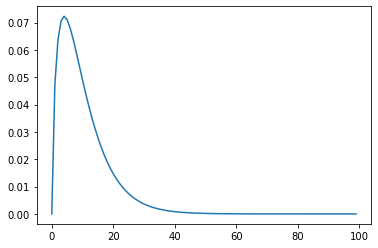

In [ ]:
import matplotlib.pyplot as plt

import scipy.special as sps  

mean = 10

scale = mean * .6
shape = mean/scale

mode = (shape-1)*scale

x = np.arange(0,100)

y = x**(shape-1)*(np.exp(-x/scale) / (sps.gamma(shape)*scale**shape))

plt.plot(x, y)  

plt.show()

This is a very guessestimate of a good probability density distribution of the gap len. The actual measure should come from the fluxnet data

In [ ]:
#| export
def gen_gap_len(mean: float, min_v = 1, max_v=50): 
    scale = mean*.6
    shape = mean/scale
    while True:
        v = int(np.random.gamma(scale=scale, shape=shape))
        yield max(min(v, max_v), min_v)

In [ ]:
next(gen_gap_len(1))

2

In [ ]:
g_len = gen_gap_len(10)

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

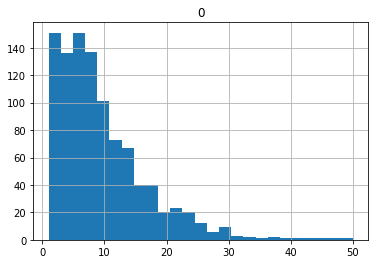

In [ ]:
gap_lens_sample = pd.DataFrame([next(g_len) for _ in range(1000)])
gap_lens_sample.hist(bins=gap_lens_sample[0].max()//2)

##### Var Sel Generator 

draws a number of variables from a uniform distribution from 1 to the max n of vars and then select the variables with equal probability

In [ ]:
#| export
def gen_var_sel(vars):
    while True:
        n_var = np.random.randint(1,1+len(vars))
        yield list(np.random.choice(np.array(vars), size=n_var, replace=False))

In [ ]:
g_var = gen_var_sel(list("abcdefg")) 

In [ ]:
[next(g_var) for _ in range(5)]

[['e', 'a', 'c', 'f', 'd', 'g', 'b'],
 ['b', 'g', 'e', 'f', 'c'],
 ['e', 'a', 'b', 'g', 'c', 'd'],
 ['a'],
 ['e', 'd', 'c', 'g', 'b', 'f', 'a']]

In [ ]:
g_var = gen_var_sel(["a", "bb", "ccc"]) 

In [ ]:
[next(g_var) for _ in range(5)]

[['ccc', 'a'],
 ['bb', 'ccc'],
 ['bb', 'ccc'],
 ['a', 'bb', 'ccc'],
 ['a', 'bb', 'ccc']]

In [ ]:
g_var = gen_var_sel(['TA', 'VPD', 'SW_IN'])

In [ ]:
[next(g_var) for _ in range(10)]

[['TA', 'VPD', 'SW_IN'],
 ['VPD', 'SW_IN'],
 ['TA'],
 ['SW_IN', 'VPD', 'TA'],
 ['SW_IN', 'VPD', 'TA'],
 ['TA', 'VPD'],
 ['VPD'],
 ['TA'],
 ['TA', 'SW_IN'],
 ['TA', 'VPD', 'SW_IN']]

In [ ]:
#| export
from fastai.data.transforms import *

In [ ]:
block_len = 10
control_lags = [1]
control_repeat = 1 + len(control_lags)
block_ids = list(range(max(control_lags), (len(hai) // block_len) - 1))[:10]
gap_len = 2
var_sel = ['TA','SW_IN']

##### Shifts generator

In [ ]:
import numpy as np

In [ ]:
def gen_shifts(var):
    """ Generate shifts for a random distribution with variances var"""
    while True:
        yield int(np.random.randn() * var)

#### Block Ids

In [ ]:
#| export
def get_block_ids(n_rep: int, # number of repetitions for each item
                  total_len: int, # total len dataframe
                  block_len: int, # len of a block
                  var_sel: Iterable|Generator, # returns `list[str]` to select variables
                  gap_len: Iterable|Generator, # returns `int` for gap len
                  shifts: Iterable|Generator|None = None, # if None make at same distance
                  offset: int = 0, # starting point for first item (for allow for control lags)
                 ):
    var_sel = as_generator(var_sel)
    gap_len = as_generator(gap_len)
    shifts = ifnone(shifts, list(range(-block_len//2, block_len//2, block_len//n_rep)))
    shifts = as_generator(shifts, iter=True)
    i_s = list(range(offset, (total_len // block_len) - 1))
    
    return [MeteoImpItem(i, next(shifts), next(var_sel), next(gap_len))
            for i in i_s for _ in range(n_rep)] # make sure have the same `i` next to each other

In [ ]:
get_block_ids(n_rep = 2, total_len = 100, block_len = 10, var_sel = ['TA'], gap_len = 10) 

[MeteoImpItem(i=0, shift=-5, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=0, shift=0, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=1, shift=-5, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=1, shift=0, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=2, shift=-5, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=2, shift=0, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=3, shift=-5, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=3, shift=0, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=4, shift=-5, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=4, shift=0, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=5, shift=-5, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=5, shift=0, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=6, shift=-5, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=6, shift=0, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=7, shift=-5, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=7, shift=0, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=8, shift=-5, var_sel=['TA'], gap_len=10),
 MeteoImpItem(i=8, shi

In [ ]:
get_block_ids(n_rep = 3, total_len = 30, block_len = 10, var_sel = gen_var_sel(['TA', 'SW_IN', 'VPD']), gap_len = 10) 

[MeteoImpItem(i=0, shift=-5, var_sel=['VPD', 'SW_IN'], gap_len=10),
 MeteoImpItem(i=0, shift=-2, var_sel=['SW_IN'], gap_len=10),
 MeteoImpItem(i=0, shift=1, var_sel=['SW_IN', 'VPD', 'TA'], gap_len=10),
 MeteoImpItem(i=1, shift=4, var_sel=['VPD', 'SW_IN', 'TA'], gap_len=10),
 MeteoImpItem(i=1, shift=-5, var_sel=['TA', 'VPD'], gap_len=10),
 MeteoImpItem(i=1, shift=-2, var_sel=['SW_IN', 'TA'], gap_len=10)]

#### Pipeline 

In [ ]:
#| export
def imp_pipeline(df,
                 control,
                 var_sel,
                 gap_len,
                 block_len,
                 control_lags,
                 n_rep,
                 shifts = None
                ):
    offset = max(control_lags)
    block_ids = get_block_ids(n_rep, len(df), block_len, var_sel, gap_len, shifts, offset)
    return [BlockIndexTransform(df.index, block_len=block_len, offset=offset),
            BlockDfTransform(data = df, control = control,  control_lags = control_lags),
            AddGapTransform(block_len//2),
            MeteoImpDf2Tensor,
            MeteoImpNormalize(*get_stats(df), *get_stats(control, 1+len(control_lags))),
            ToTuple
           ], block_ids

In [ ]:
pipeline, block_ids = imp_pipeline(hai, hai_era, var_sel, gap_len, block_len, control_lags, n_rep=10)

In [ ]:
pipeline

[BlockIndexTransform:
 encodes: (MeteoImpItem,object) -> encodes
 decodes: ,
 BlockDfTransform:
 encodes: (MeteoImpIndex,object) -> encodes
 decodes: ,
 AddGapTransform:
 encodes: (DataControl,object) -> encodes
 decodes: ,
 __main__.MeteoImpDf2Tensor,
 MeteoImpNormalize -- {'mean_data': tensor([  8.3339, 120.9578,   3.3807], dtype=torch.float64), 'std_data': tensor([  7.9246, 204.0026,   4.3684], dtype=torch.float64), 'mean_control': tensor([  8.1948, 120.6864,   3.3253,   8.1948, 120.6864,   3.3253],
        dtype=torch.float64), 'std_control': tensor([  7.5459, 187.1730,   3.6871,   7.5459, 187.1730,   3.6871],
        dtype=torch.float64)}:
 encodes: (MeteoImpTensor,object) -> encodes
 decodes: (MeteoImpTensor,object) -> decodes,
 __main__.ToTuple]

In [ ]:
pp = Pipeline(pipeline)

In [ ]:
pp

Pipeline: BlockIndexTransform -> BlockDfTransform -> AddGapTransform -> MeteoImpDf2Tensor -> MeteoImpNormalize -- {'mean_data': tensor([  8.3339, 120.9578,   3.3807], dtype=torch.float64), 'std_data': tensor([  7.9246, 204.0026,   4.3684], dtype=torch.float64), 'mean_control': tensor([  8.1948, 120.6864,   3.3253,   8.1948, 120.6864,   3.3253],
       dtype=torch.float64), 'std_control': tensor([  7.5459, 187.1730,   3.6871,   7.5459, 187.1730,   3.6871],
       dtype=torch.float64)} -> ToTuple

### Dataloader

random splitter for validation/training set

In [ ]:
reset_seed()

In [ ]:
splits = EndSplitter()(block_ids) # last 80% is test data

Repeat twice the pipeline since is the same pipeline both for training data and for labels.

In theory could optimize the label creation and get the data only from the gap and not the control, but for now it works and the overhead is minimal

In [ ]:
dls = TfmdLists(block_ids, pipeline, splits=splits).dataloaders(bs=2)

In [ ]:
dls.one_batch()

((tensor([[[-0.3298, -0.5929, -0.5640],
           [-0.3563, -0.5929, -0.6420],
           [-0.3387, -0.5929, -0.6720],
           [-0.3261, -0.5929, -0.6722],
           [-0.3248, -0.5929, -0.6924],
           [-0.3172, -0.5929, -0.7105],
           [-0.3071, -0.5929, -0.7066],
           [-0.2933, -0.5929, -0.6883],
           [-0.2907, -0.5767, -0.6901],
           [-0.2882, -0.5386, -0.6929]],
  
          [[-0.7097, -0.3020, -0.7189],
           [-0.6971, -0.3474, -0.7192],
           [-0.6857, -0.2052, -0.7045],
           [-0.6630, -0.0902, -0.6656],
           [-0.6390,  0.0122, -0.6276],
           [-0.6062,  0.4852, -0.5859],
           [-0.5709,  0.7880, -0.5388],
           [-0.5406,  0.5899, -0.5024],
           [-0.5267,  0.4234, -0.5015],
           [-0.4901,  0.7530, -0.4832]]], device='cuda:0', dtype=torch.float64),
  tensor([[[ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True, 

In [ ]:
dls.device

device(type='cuda', index=0)

In [ ]:
@typedispatch
def show_batch(x: tuple, y, samples, ctxs=None, max_n=6):
    return x

In [ ]:
# dls.show_batch()

In [ ]:
dls._types

{tuple: [{tuple: [torch.Tensor, torch.Tensor, torch.Tensor]},
  {tuple: [torch.Tensor, torch.Tensor, torch.Tensor]}]}

In [ ]:
from fastcore.foundation import *

In [ ]:
#| export
def imp_dataloader(df,
                 control,
                 var_sel,
                 gap_len,
                 block_len,
                 control_lags,
                 n_rep,  
                 bs):
    pipeline, block_ids = imp_pipeline(df, control, var_sel, gap_len, block_len, control_lags, n_rep)
    splits = EndSplitter()(block_ids)
    ds = TfmdLists(block_ids, pipeline, splits=splits)
    
    return ds.dataloaders(bs=bs)
    

In [ ]:
imp_dataloader

<function __main__.imp_dataloader(df, control, var_sel, gap_len, block_len, control_lags, n_rep, bs)>

In [ ]:
dls = imp_dataloader(hai, hai_era, var_sel, gap_len=10, block_len=200, control_lags=[1], n_rep = 20, bs=10).cpu()

In [ ]:
dls.one_batch()[0][0].shape

torch.Size([10, 200, 3])

In [ ]:
dls = dls.cpu()

## Model

### Data type

this is the datatype that is the output of the model, which is a custom class class that both supports fastai processing and has convinience functions

In [ ]:
#| export
class MNormalsParams(list):
    def __init__(self,*args):
        if len(args)==2:
            self.mean = args[0]
            self.cov = args[1]
        elif isinstance(args[0], Generator):
            args = list(args[0])
            self.mean = args[0]
            self.cov = args[1]
        elif len(args)==1 and len(args[0])==2:
            self.mean = tuple(args[0])[0]
            self.cov = tuple(args[0])[1]                     
        else:
            raise ValueError(f"Incorrect number of arguments. got {len(args)} args")
    def __iter__(self): return iter((self.mean, self.cov,))
    def __next__(self): return next(self.__iter__())
    def __len__(self): return 2
    def __getitem__(self, key):
        if key == 0: return self.mean
        elif key == 1: return self.cov
        else: raise IndexError("index bigger than 2")
    __repr__ = basic_repr('mean, cov')
    def squeeze(self,i):
        self.mean.squeeze_(i)
        self.cov.squeeze_(i)
        return self

In [ ]:
#| export
class NormalsParams(list):
    def __init__(self,*args):
        if len(args)==2:
            self.mean = args[0]
            self.std = args[1]
        elif isinstance(args[0], Generator):
            args = list(args[0])
            self.mean = args[0]
            self.std = args[1]
        elif len(args)==1 and len(args[0])==2:
            self.mean = tuple(args[0])[0]
            self.std = tuple(args[0])[1]                     
        else:
            raise ValueError(f"Incorrect number of arguments. got {len(args)} args")
    def __iter__(self): return iter((self.mean, self.std,))
    def __next__(self): return next(self.__iter__())
    def __len__(self): return 2
    def __getitem__(self, key):
        if key == 0: return self.mean
        elif key == 1: return self.std
        else: raise IndexError("index bigger than 2")
    __repr__ = basic_repr('mean, std')

In [ ]:
NormalsParams(0,1)

__main__.NormalsParams(mean=0, std=1)

In [ ]:
MNormalsParams(0,1)

__main__.MNormalsParams(mean=0, cov=1)

### Forward Function

in order to the a pytorch module we need a forward method to the kalman filter

In [ ]:
#| export
from meteo_imp.kalman.filter import *
from torch.distributions import MultivariateNormal

In [ ]:
model = KalmanFilterSR.init_random(n_dim_obs = hai.shape[-1], n_dim_state = hai.shape[-1], n_dim_contr = hai_era.shape[-1]*control_repeat)

In [ ]:
type(model)

meteo_imp.kalman.filter.KalmanFilterSR

In [ ]:
control_repeat

2

In [ ]:
model

Kalman Filter
        N dim obs: 3,
        N dim state: 3,
        N dim contr: 6

In [ ]:
input = dls.one_batch()[0]

In [ ]:
model._predict_filter(*input);

In [ ]:
#| export
@patch
def forward(self: KalmanFilter|KalmanFilterSR, meteo_data: MeteoImpTensor):
    data, mask, control = meteo_data
    assert not data.isnan().any()
    use_smooth = self.use_smooth if hasattr(self, 'use_smooth') else True
    
    mean, cov = (self.predict(obs=data, mask=mask, control=control, smooth=True) if use_smooth
                        else self._predict_filter(data, mask, control))
    return MNormalsParams(mean, cov) # to have fastai working this needs to be a tuple subclass

In [ ]:
model.pred_std

False

In [ ]:
pred = model.predict(*input)
pred.mean.shape, pred.cov.shape

(torch.Size([10, 200, 3]), torch.Size([10, 200, 3, 3]))

In [ ]:
input = dls.one_batch()[0]
target = dls.one_batch()[1]

In [ ]:
model.state_dict()

OrderedDict([('A',
              tensor([[[0.0937, 0.6706, 0.1638],
                       [0.9272, 0.2620, 0.4967],
                       [0.2630, 0.1175, 0.1694]]], dtype=torch.float64)),
             ('H',
              tensor([[[0.6441, 0.2801, 0.9132],
                       [0.0329, 0.4856, 0.9927],
                       [0.5895, 0.2611, 0.9413]]], dtype=torch.float64)),
             ('B',
              tensor([[[0.6319, 0.6734, 0.7937, 0.6468, 0.5825, 0.4599],
                       [0.7960, 0.9038, 0.9735, 0.6428, 0.3725, 0.2052],
                       [0.0507, 0.4448, 0.5775, 0.7237, 0.5927, 0.3217]]],
                     dtype=torch.float64)),
             ('Q_raw',
              tensor([[[0.4760, 0.0000, 0.0000],
                       [0.5243, 0.3714, 0.0000],
                       [0.2343, 0.9991, 0.1775]]], dtype=torch.float64)),
             ('R_raw',
              tensor([[[0.8451, 0.0000, 0.0000],
                       [0.0462, 0.2360, 0.0000],
                  

In [ ]:
data = input[0][0]
data.shape

torch.Size([200, 3])

In [ ]:
mask = input[1][0]
control = input[2][0]

In [ ]:
mask.shape

torch.Size([200, 3])

In [ ]:
data.device

device(type='cpu')

In [ ]:
torch.device

torch.device

In [ ]:
data.shape, mask.shape

(torch.Size([200, 3]), torch.Size([200, 3]))

In [ ]:
model.predict(data.unsqueeze(0), mask.unsqueeze(0), control.unsqueeze(0));

In [ ]:
model.use_smooth = True

In [ ]:
pred = model(input)

In [ ]:
pred[0].shape

torch.Size([10, 200, 3])

In [ ]:
pred[1].shape

torch.Size([10, 200, 3, 3])

In [ ]:
model.use_smooth = False

In [ ]:
pred_filt = model(input)

In [ ]:
pred_filt[1].shape

torch.Size([10, 200, 3, 3])

In [ ]:
type(pred), type(pred_filt)

(__main__.MNormalsParams, __main__.MNormalsParams)

In [ ]:
pred_filt.mean.shape, pred_filt.cov.shape

(torch.Size([10, 200, 3]), torch.Size([10, 200, 3, 3]))

In [ ]:
test_ne(pred, pred_filt)

### Loss Function

add support for complete loss (also outside gap) and for filter loss (don't run the smooher)

There are two ways to compute the loss, one is to do it for all predictions the other is for doing it for only the gap
- only_gap

Play around with flatting + diagonal

In [ ]:
means, covs = pred
data, mask, contr = target

In [ ]:
pred.mean.shape, pred.cov.shape

(torch.Size([10, 200, 3]), torch.Size([10, 200, 3, 3]))

In [ ]:
#| export
def get_only_gap(mask, *args):
    """for each element in arg return only the portion where there is a gap at the time level"""
    gap_mask = ~mask.all(-1)
    return [x[gap_mask] for x in args]

In [ ]:
#| export
class KalmanLoss():
    def __init__(self,
                 only_gap:bool=False, # loss for all predictions or only gap. Expects predictions only for gap
                 use_std:bool=False, # loss on stds otherwise with full cov matrices.
                 reduction:str='mean', # one of ['sum', 'mean', 'none'] reduction between batches
                 reduction_inbatch:str='sum', # one of ['sum', 'mean', 'none'] reduction inside a batch
                ):
        store_attr()
    
    def __call__(self, pred: NormalsParams, target: MeteoImpTensor):
        data, mask, _ = target
        means, covs = pred        
        # assert not covs.isnan().any(), "Nan in prediction"
        losses = torch.empty(len(data), device=data.device, dtype=data.dtype)
        for i, (d, m, mean, cov) in enumerate(zip(data, mask, means, covs)):
            losses[i] = self._loss_batch(d,m,mean, cov)
        return self._reduce(losses, self.reduction)
    
    def _loss_batch(self, datas, masks, means, covs):
        if self.only_gap:
            # here means and covs are already masked, while data and mask is not
            datas, masks = get_only_gap(masks, datas, masks)
        
        assert len(datas) == len(means)
        losses = torch.zeros(len(datas), device=datas.device, dtype=datas.dtype)
        for i, (data, mask, mean, cov) in enumerate(zip(datas, masks, means, covs)):
            if self.use_std: cov = torch.diag(cov.diag()) # keep only diagonal of covariance
            if self.only_gap:
                data = data[~mask]
            losses[i] = - MultivariateNormal(mean, cov).log_prob(data)
        return self._reduce(losses, self.reduction_inbatch)
    
    @staticmethod
    def _reduce(losses, reduction):
        if reduction == 'none': return losses
        elif reduction == 'mean': return losses.mean()
        elif reduction == 'sum': return losses.sum()
        else: raise ValueError(f"invalid reduction {reduction}")

        

In [ ]:
input  = target = imp_dataloader(hai, hai_era, var_sel, gap_len=5, block_len=10, control_lags=[1], n_rep = 1, bs=2).cpu().one_batch()[0]

In [ ]:
model = KalmanFilterSR.init_random(n_dim_obs = hai.shape[-1], n_dim_state = hai.shape[-1], n_dim_contr = hai_era.shape[-1]*control_repeat)

In [ ]:
model.use_smooth = True
# model.pred_only_gap = False
# model.use_conditional = False
pred = model(input)

In [ ]:
pred.cov[0][0].shape

torch.Size([3, 3])

In [ ]:
KalmanLoss()(pred, target)

tensor(41.0144, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
KalmanLoss(use_std=True)(pred, target)

tensor(42.0821, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
KalmanLoss(reduction='mean')(pred, target)

tensor(41.0144, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
KalmanLoss(reduction_inbatch='mean')(pred, target)

tensor(4.1014, dtype=torch.float64, grad_fn=<MeanBackward0>)

#### Only Gap 

In [ ]:
model_gap = KalmanFilterSR.init_random(n_dim_obs = hai.shape[-1], n_dim_state = hai.shape[-1], n_dim_contr = hai_era.shape[-1]*control_repeat, pred_only_gap = True, use_conditional=True)

In [ ]:
input_gap = target_gap = imp_dataloader(hai, hai_era, var_sel, gap_len=5, block_len=10, control_lags=[1], n_rep = 1, bs=2).cpu().one_batch()[0]

In [ ]:
pred_gap = model_gap(input_gap)

In [ ]:
KalmanLoss(only_gap=True)(pred_gap, target_gap)

tensor(16.7517, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
KalmanLoss(only_gap=True)(pred_gap, target_gap).backward(retain_graph=True)

### Metrics

In [ ]:
#| export
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
pred0, targ = target[0][0].detach().cpu(), pred[0][0].detach().cpu() 

In [ ]:
pred0.shape, targ.shape

(torch.Size([10, 3]), torch.Size([10, 3]))

The shape of the input is very important for the r2score, which cannot be batched and requires a needs to keep the multidimensional input

$$ R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $$

In [ ]:
r2_score(pred0, targ)

-5.453314298102831e+30

In [ ]:
r2_score(pred0, targ, multioutput="raw_values")

array([-2.78653154e+03, -1.63599429e+31, -2.51204379e+03])

In [ ]:
r2_score(pred0.flatten(), targ.flatten())

-1.6828946794067599

While for the `rmse` is okay to batch and flatten input. The only difference is how the mean is computed, which is a minor difference

In [ ]:
mean_squared_error(pred0, targ)

0.9457540307065053

In [ ]:
mean_squared_error(pred0.flatten(), targ.flatten())

0.9457540307065052

Wrapper around fastai metrics to support masked tensors and normal distributions

In [ ]:
#| export
from fastai.metrics import *

The problem is that fastai metrics by default flatten everything ... so need to reimplement them

In [ ]:
myr2 = skm_to_fastai(r2_score, flatten=False)

In [ ]:
myr2(pred[0][0], target[0][0])

-5.453314298102831e+30

but the mask is still flattening the data ....

In [ ]:
m = target[1][0]
m.shape

torch.Size([10, 3])

need to get the mask as a matrix and not as a vector, so drop columns and rows that are all true and then check the resulting mask is all False

In [ ]:
mask_sub = m[:, ~m.all(0)][~m.all(1),:]
mask_sub

tensor([[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]])

In [ ]:
~mask_sub.any()

tensor(True)

In [ ]:
m2 = m.clone()
m2[0,0] = False
m2[:, ~m2.all(0)][~m2.all(1),:]

tensor([[False,  True],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]])

In [ ]:
#| export
from fastai.learner import AvgMetric
import torch.nn.functional as F

In [ ]:
#| export
class ImpMetric(AvgMetric):
    def __init__(self, metric, base_name, only_gap=False, flatten=False):
        store_attr()
    @property
    def name(self): return  self.base_name + ("_gap" if self.only_gap else "")
    def _metric_batch(self, pred, targ):
        return self.metric(pred, targ)
    def _metric_batch_gap(self, pred_list, targ, mask):
        targ, mask = get_only_gap(mask, targ, mask)
        assert len(pred_list) == len(targ)
        pred = torch.vstack(pred_list) # convert to tensor
        row_sel, col_sel = ~mask.all(1), ~mask.all(0)
        assert not mask[:, col_sel][row_sel, :].any(), "More than 1 gap uniform not supported"
        return self.metric(pred[:, col_sel[col_sel]][row_sel, :], targ[:, col_sel][row_sel, :])
    def __call__(self, *args): return self.func(*args)
    def func(self, pred: NormalsParams, targ: MeteoImpTensor):
        mean, _ = pred
        data, mask, _ = targ
        metric_values = torch.empty(len(mean))
        for i in range(metric_values.shape[0]):
            metric_values[i] = (self._metric_batch_gap(mean[i], data[i], mask[i]) if self.only_gap
            else self._metric_batch(mean[i], data[i]))
        return metric_values.mean().item()
    

In [ ]:
#| export
def imp_rmse(preds, targs):
    return torch.sqrt(F.mse_loss(preds, targs))

In [ ]:
#| export
rmse_mask = ImpMetric(imp_rmse, 'rmse')
rmse_gap = ImpMetric(imp_rmse, 'rmse', only_gap=True)

In [ ]:
rmse_mask.name, rmse_gap.name

('rmse', 'rmse_gap')

In [ ]:
rmse_mask(pred, target)

0.7026374340057373

In [ ]:
model_gap = KalmanFilterSR.init_random(n_dim_obs = hai.shape[-1], n_dim_state = hai.shape[-1], n_dim_contr = hai_era.shape[-1]*control_repeat, pred_only_gap = True, use_conditional=True)

In [ ]:
input_gap = target_gap = imp_dataloader(hai, hai_era, var_sel, gap_len=5, block_len=10, control_lags=[1], n_rep = 1, bs=2).cpu().one_batch()[0]

In [ ]:
pred_gap = model_gap(input)

In [ ]:
rmse_gap(pred_gap, target)

1.0300066471099854

In [ ]:
#| export
multi_r2 = skm_to_fastai(r2_score, flatten=False)
r2_mask = ImpMetric(multi_r2, 'r2')
# r2_gap = ImpMetric(multi_r2, 'r2', only_gap=True)

In [ ]:
r2_mask.name

'r2'

In [ ]:
r2_mask(pred, target)

-3.7690429426017724e+30

In [ ]:
#| export
imp_metrics =  [rmse_mask, rmse_gap]

### Callback

save the model state 

In [ ]:
#| export
from fastai.callback.all import *

In [ ]:
#| export
class SaveParams(Callback):
    def __init__(self, param_name):
        super().__init__()
        self.params = []
        self.param_name = param_name
    def after_batch(self):
        param = getattr(self.model, self.param_name).detach()
        self.params.append(param)

In [ ]:
#| export
class SaveParams(Callback):
    def __init__(self, param_name):
        super().__init__()
        self.params = []
        self.param_name = param_name
    def after_batch(self):
        param = getattr(self.model, self.param_name).detach()
        self.params.append(param)

In [ ]:
debug_preds = []

In [ ]:
class DebugPredCallback(Callback):
    order = 0
    def after_validate(self):
        if hasattr(self, 'gather_preds'):
            debug_preds.append(self.gather_preds.preds)

### Learner

In [ ]:
#| export
from fastai.learner import * 

from fastai.tabular.all import *

from fastai.tabular.learner import *

from fastai.callback.progress import ShowGraphCallback

In [ ]:
obs_cov_history = SaveParams('obs_cov')

In [ ]:
all_data = CollectDataCallback()

In [ ]:
model = KalmanFilterSR.init_random(n_dim_obs = hai.shape[1], n_dim_state = hai.shape[1], n_dim_contr = hai_era.shape[-1]*control_repeat)#.cuda()

In [ ]:
# model._set_constraint('obs_cov', model.obs_cov, train=False)

In [ ]:
dls = imp_dataloader(hai[10_000:11_000], hai_era, ['TA'], gap_len=5, block_len=20, control_lags=[1], n_rep=1, bs=2).cpu()

In [ ]:
dls.one_batch()[0][0].device

device(type='cpu')

In [ ]:
input, target = dls.one_batch()

In [ ]:
pred = model(input)
KalmanLoss()(pred, target)

tensor(77.3169, dtype=torch.float64, grad_fn=<MeanBackward0>)

#### Float64

In [ ]:
#| export
class Float64Callback(Callback):
    order = Recorder.order + 10 # run after Recorder 
    def before_fit(self):
        self.recorder.smooth_loss.val = torch.tensor(0, dtype=torch.float64) # default is a float 32

In [ ]:
rmse

<fastai.metrics.AccumMetric>

In [ ]:
learn = Learner(dls, model, loss_func=KalmanLoss(), cbs = [Float64Callback] , metrics = rmse_mask)

In [ ]:
learn.fit(1, 1e-3)

epoch,train_loss,valid_loss,rmse,time
0,85.751491,103.748098,1.555595,00:03


#### Only gap

In [ ]:
learn_gap = Learner(dls, model_gap, loss_func=KalmanLoss(only_gap=True), cbs = [DebugPredCallback, Float64Callback] , metrics = [rmse_gap])

In [ ]:
pred_gap = learn_gap.model(dls.one_batch()[0])

In [ ]:
KalmanLoss(only_gap=True)(pred_gap, dls.one_batch()[0])

tensor(6.6916, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
learn_gap.fit(1, 1e-3)

epoch,train_loss,valid_loss,rmse_gap,time
0,5.229680,12.176460,1.339469,00:03


In [ ]:
learn.loss

## Predictions

The transformation pipeline is not working properly (there is a problem in `decode_batch` as the `_types` are more nested than the predictions, which results in an error) + the pipeline is anyway not reproducible + the test dataloaders seems that they are actually not deterministic .....
soo reimplement everything almost from scratch

see https://github.com/mone27/meteo_imp/blob/0335003405ec9bd3e3bd2641bc6d7924f34a0788/lib_nbs/kalman/10_fastai.ipynb for all details

### Predictions from custom items

In [ ]:
#| export
def one_batch_with_items(dls, items):
    """ Makes custom dataloader that returns only one batch with items"""
    new_ds = dls.dataset.copy()
    items = listify(items)
    new_ds.items =items
    return dls.new(bs = len(items), dataset = new_ds, shuffle=False).one_batch()

In [ ]:
items = [MeteoImpItem(1,0, 'TA', 5), MeteoImpItem(2,0, 'TA', 5)]

In [ ]:
input, _ = one_batch_with_items(dls, items)

In [ ]:
# test that there is no shuffling
batch0 = one_batch_with_items(dls, items) 
for _ in range(5):
    test_close(batch0[0][0], one_batch_with_items(dls, items)[0][0])

In [ ]:
preds = learn.model(input)
preds_gap = learn_gap.model(input)

### Predictions Transform Pipeline

Need to transform the predictions into a format that can be used (for plotting)

The steps are:

1. convert covariance to std
2. maybe buffer predictions if they are only for gap
3. inverse normalize
4. get original target (not transformed)
5. transform to dataframe (with proper index/col names)

#### 1) Cov 2 Std 

Transform covariance to std supporting also only gaps predictions 

In [ ]:
#| export
class CovStdTransform(Transform):
    def encodes(self, x: MNormalsParams) -> NormalsParams:
        return NormalsParams(x.mean, self(x.cov))
    def encodes(self, x: torch.Tensor): return cov2std(x)
    def encodes(self, x: list):
        return [self(o) for o in x]

In [ ]:
CovStdTransform()

CovStdTransform:
encodes: (MNormalsParams,object) -> encodes
(Tensor,object) -> encodes
(list,object) -> encodes
decodes:

In [ ]:
type(preds)

__main__.MNormalsParams

In [ ]:
preds_0 = learn.model(input)
preds_1 = CovStdTransform()(preds_0)
preds_1.std.shape

torch.Size([2, 20, 3])

In [ ]:
preds_gap_0 = learn_gap.model(input)
preds_gap_1 = CovStdTransform()(preds_gap_0)
preds_gap_1.std

[[tensor([0.9518], dtype=torch.float64, grad_fn=<SqrtBackward0>),
  tensor([0.9519], dtype=torch.float64, grad_fn=<SqrtBackward0>),
  tensor([0.9520], dtype=torch.float64, grad_fn=<SqrtBackward0>),
  tensor([0.9515], dtype=torch.float64, grad_fn=<SqrtBackward0>),
  tensor([0.9508], dtype=torch.float64, grad_fn=<SqrtBackward0>)],
 [tensor([0.9518], dtype=torch.float64, grad_fn=<SqrtBackward0>),
  tensor([0.9519], dtype=torch.float64, grad_fn=<SqrtBackward0>),
  tensor([0.9520], dtype=torch.float64, grad_fn=<SqrtBackward0>),
  tensor([0.9515], dtype=torch.float64, grad_fn=<SqrtBackward0>),
  tensor([0.9508], dtype=torch.float64, grad_fn=<SqrtBackward0>)]]

#### 2) Buffer gap only preds

in addition detach and move to CPU

In [ ]:
#| export
def buffer_pred_single(preds: list[Tensor],
                masks: Tensor) -> Tensor:
    """For predictions are for gaps only add buffer of `Nan` so they have same shape of targets"""
    all_pred = torch.empty(masks.shape, dtype=preds[0][0].dtype).fill_(torch.nan)
    i_p = 0
    for i, (mask) in enumerate(masks.cpu()):
        if not mask.all():
            all_pred[i][~mask] = preds[i_p].detach().cpu()
            i_p += 1
    assert i_p == len(preds)
    return all_pred

In [ ]:
#| export
def buffer_pred(preds: list[list[Tensor]],
                masks: Tensor) -> Tensor:
    """For predictions are for gaps only add buffer of `Nan` so they have same shape of targets"""
    return torch.stack([buffer_pred_single(pred, mask) for pred, mask in zip(preds, masks)])

In [ ]:
#| export
def maybe_buffer_pred(preds, masks):
    """If predictions are for gaps only add buffer so they have same shape of targets"""
    if not isinstance(preds.mean, torch.Tensor):
        return NormalsParams(buffer_pred(preds.mean, masks), buffer_pred(preds.std, masks))
    else:
        return NormalsParams(preds.mean.detach().cpu(), preds.std.detach().cpu())

In [ ]:
preds_2 = maybe_buffer_pred(preds_1, input[1])
test_eq(preds_1, preds_2)

In [ ]:
preds_gap_2 = maybe_buffer_pred(preds_gap_1, input[1])
test_eq(preds_2.mean.shape, preds_gap_2.mean.shape)

In [ ]:
assert (preds_gap_2.mean.isnan() == input[1]).all()

#### 3) Inverse Normalize

here we use the decode step of the normalizer in the dataloader

In [ ]:
def get_stats_np(*args):
    stats = get_stats(*args)
    return (stats[0].numpy(), stats[1].numpy())

In [ ]:
#| export
def _maybe2np(x): return x.cpu().numpy() if isinstance(x, torch.Tensor) else x

In [ ]:
#| export
class InverseNormalize(Transform):
    def __init__(self, mean, std):
        self.mean_data = _maybe2np(mean)
        self.std_data = _maybe2np(std)
    def encodes(self, x:NormalsParams):
        mean = x.mean * self.std_data + self.mean_data
        std = x.std * self.std_data
        return NormalsParams(mean, std)
    @classmethod
    def from_dls(cls, dls):
        return cls(dls.fs[-2].mean_data, dls.fs[-2].std_data)

In [ ]:
preds_3 = InverseNormalize.from_dls(dls)(preds_2)
preds_2.mean.mean(-2), preds_3.mean.mean(-2)

(tensor([[-0.7074, -0.1073, -0.9393],
         [-1.0340, -0.0575, -1.3888]], dtype=torch.float64),
 tensor([[ 14.6161, 176.2020,   2.1360],
         [ 13.4475, 188.4713,   0.4957]], dtype=torch.float64))

In [ ]:
preds_gap_3 = InverseNormalize.from_dls(dls)(preds_gap_2)
torch.nanmean(preds_gap_2.mean, -2), torch.nanmean(preds_gap_3.mean, -2)

(tensor([[-0.6510,     nan,     nan],
         [-0.4523,     nan,     nan]], dtype=torch.float64),
 tensor([[14.8175,     nan,     nan],
         [15.5284,     nan,     nan]], dtype=torch.float64))

#### 4) Original target

we need the target as a dataframe and not transformed, so we use the first part of the dls pipeline + custom aggregation to a list

In [ ]:
#| export
def orig_target(dls, items):
    pipe = Pipeline(dls.fs[:3])
    return [pipe(item) for item in items]

In [ ]:
targs = orig_target(dls, items)
len(targs), type(targs[0])

(2, __main__.MeteoImpDf)

In [ ]:
for targ, o_targ in zip(input[1], targs):
    test_eq(targ.numpy(), o_targ.mask.to_numpy())

#### 5) To Dataframe

In [ ]:
#| export
class NormalsDf:
    """DataFrames of Normal parameters (mean and std)"""
    def __init__(self, mean, std): store_attr()
    def tidy(self, prefix=""):
        """Tidy version"""
        mean = self.mean.reset_index().melt("time", value_name=prefix + "mean")
        std = self.std.reset_index().melt("time", value_name=prefix + "std")
        return pd.merge(mean, std, on=["time", "variable"])
    __repr__ = basic_repr("mean, std")
    @classmethod
    def from_preds(cls,
                   mean: Tensor,
                   std: Tensor,
                   targ: MeteoImpDf):
        """Convert prediction to dataframe using index/columns form target """
        mean = pd.DataFrame(mean.numpy(), columns = targ.data.columns, index=targ.data.index)
        std = pd.DataFrame(std.numpy(), columns = targ.data.columns, index=targ.data.index)
        return cls(mean, std)
    def _repr_html_(self):
        return row_dfs({'data': self.mean, 'std': self.std}, title="Normals Df", hide_idx=False)

In [ ]:
#| export
def preds2df(preds: NormalsParams, targs):
    return [NormalsDf.from_preds(preds.mean[i], preds.std[i], targs[i]) for i in range(len(targs))]

In [ ]:
preds_5 = preds2df(preds_3, targs)
preds_gap_5 = preds2df(preds_gap_3, targs)

### Get Predictions

Now combine all the steps above in one function that takes as argument:
- model
- dataloader
- items

and returns inverse transformed `preds`, `targs` and `metrics`

In [ ]:
#| export
def unsqueeze_maybe_list(x):
    """add a dimension in front if Tensor and make a list of x if x is a list"""
    return x.unsqueeze(0) if isinstance(x, torch.Tensor) else [x]
def _n_tuple(x, n, unsqueeze = True):
    """get the nth element of for every element of a tuple"""
    f = unsqueeze_maybe_list if unsqueeze else noop
    return type(x)(tuple(f(o[n]) for o in x))

In [ ]:
_n_tuple(preds, 0).mean.shape

torch.Size([1, 20, 3])

In [ ]:
_n_tuple(preds_gap, 0).mean.__len__()

1

In [ ]:
_n_tuple(input, 0)[0].__len__()

1

In [ ]:
_n_tuple(input, 0, False)[0].__len__()

20

In [ ]:
#| export
class PredMetrics:
    def __init__(self, learn):
        self.metrics = {metric.name: metric for metric in learn.metrics} | {'loss': learn.loss_func}
    def __call__(self, preds, targs):
        out = []
        for i in range(len(preds.mean)):
            out.append({name: metric(_n_tuple(pred, i), _n_tuple(targ, i)) for name, metric in self.metrics.items()})
        return out

In [ ]:
#| export
def predict_items(
    model: KalmanFilterBase,
    dls: DataLoaders,
    items: list[list],
    # metric_fn: PredMetrics
):
    input, _ = one_batch_with_items(dls, items)
    preds_0 = model(input)
    preds_1 = CovStdTransform()(preds_0)
    preds_2 = maybe_buffer_pred(preds_1, input[1])
    preds_3 = InverseNormalize.from_dls(dls)(preds_2) # inverse normalize
    targs = orig_target(dls, items)
    preds_5 = preds2df(preds_3, targs)
    
    # metrics = metric_fn(preds_0, input)
    
    return preds_5, targs, #metrics

In [ ]:
f_preds, f_targs = predict_items(learn.model, dls, items)
len(f_preds)

NotImplementedError: Module [KalmanFilterSR] is missing the required "forward" function

In [ ]:
f_preds, f_targs = predict_items(learn.model, dls, items + [MeteoImpItem(3,2,'TA', 10)])
len(f_preds)

3

In [ ]:
learn_gap.model.use_conditional = False

In [ ]:
f_preds_gap, f_targs_gap = predict_items(learn_gap.model, dls, items + [MeteoImpItem(3,4, 'TA', 10)])
len(f_preds)

3

In [ ]:
f_preds[0]

,TA,SW_IN,VPD
time,,,
2000-07-27 19:00:00,-0.3581,0.1802,-0.5180
2000-07-27 19:30:00,-0.0101,0.0818,-0.3343
2000-07-27 20:00:00,-0.1109,0.0406,-0.2874
2000-07-27 20:30:00,-0.5550,-0.2125,-0.7877
2000-07-27 21:00:00,-0.6815,-0.2260,-0.9041
2000-07-27 21:30:00,-0.6875,-0.1890,-0.9122
2000-07-27 22:00:00,-0.6653,-0.1369,-0.8785
2000-07-27 22:30:00,-0.6858,-0.1078,-0.8931
2000-07-27 23:00:00,-0.7233,-0.0973,-0.9403


In [ ]:
f_preds_gap[0]

,TA,SW_IN,VPD
time,,,
2000-07-27 19:00:00,nan,nan,nan
2000-07-27 19:30:00,nan,nan,nan
2000-07-27 20:00:00,nan,nan,nan
2000-07-27 20:30:00,nan,nan,nan
2000-07-27 21:00:00,nan,nan,nan
2000-07-27 21:30:00,nan,nan,nan
2000-07-27 22:00:00,nan,nan,nan
2000-07-27 22:30:00,nan,nan,nan
2000-07-27 23:00:00,nan,nan,nan


### Only Gap Context manager

In [ ]:
#| export
from fastcore.xtras import ContextManagers
from fastai.learner import replacing_yield

In [ ]:
#| export
def only_gap_ctx(learn, only_gap=True):
    @contextmanager
    def _set_model(): return replacing_yield(learn.model, 'pred_only_gap', only_gap)
    @contextmanager
    def _set_loss(): return replacing_yield(learn.loss_func, 'only_gap', only_gap)
    @contextmanager
    def _set_metric(): return replacing_yield(learn, 'metrics', [rmse_gap] if only_gap else [rmse_mask])
    @contextmanager
    def _set_cond(): 
        if only_gap and learn.model.use_conditional:
            return replacing_yield(learn.model, 'use_conditional', False)
        else:
            yield True
    return ContextManagers([_set_model(), _set_loss(), _set_metric(), _set_cond()])

In [ ]:
with only_gap_ctx(learn):
    print(learn.model.pred_only_gap)
    print(learn.loss_func.only_gap)
    print(learn.metrics[0].only_gap)
print(learn.model.pred_only_gap)

True
True
True
False


In [ ]:
from meteo_imp.kalman.filter import with_settings

In [ ]:
with with_settings(learn.model, use_conditional=False, pred_only_gap=True):
    pred_gap_buff = buffer_pred(learn.model.predict(*input).mean, input[1])[0]
mask_na = ~pred_gap_buff.isnan()
with with_settings(learn.model, use_conditional=False, pred_only_gap=False):
    pred_ng = learn.model.predict(*input).mean[0]

In [ ]:
test_close(pred_gap_buff[mask_na], pred_ng[mask_na])

### Plotting

#### Plot results

In [ ]:
#| export
def format_metric(name, val):
    val = f"{val:.5}" if abs(val) <1 else f"{val:.5E}"
    return f"{name}: {val}"

In [ ]:
#| export
@delegates(facet_variable)
def plot_result(pred, targ, metrics=None, control_map=None, hide_no_gap=False, **kwargs):
    df = pd.merge(targ.tidy(control_map), pred.tidy(), on=["time", "variable"])

    title =  [format_metric(name, val) for name, val in metrics.items()] if metrics else ""
    if hide_no_gap:
        show_vars = targ.data.columns[~targ.mask.all()] # only variables with a gap
        df = df[df.variable.isin(show_vars)]
    return facet_variable(df, ys=["value", "mean", "control"], error=True, control=bool(control_map), **kwargs).properties(title=title)

In [ ]:
f_targs[0].data.columns[~f_targs[0].mask.all()]

Index(['TA'], dtype='object')

In [ ]:
plot_result(f_preds[0], f_targs[0], units=units)

alt.VConcatChart(...)

In [ ]:
with only_gap_ctx(learn):
    f_preds_gap, f_targs_gap = predict_items(learn.model, dls, items)
    display(plot_result(f_preds_gap[0], f_targs_gap[0]))

alt.VConcatChart(...)

In [ ]:
with only_gap_ctx(learn):
    f_preds_gap, f_targs_gap = predict_items(learn.model, dls, items)
    display(plot_result(f_preds_gap[0], f_targs_gap[0], hide_no_gap=True))

alt.VConcatChart(...)

In [ ]:
plot_result(f_preds[0], f_targs[0],control_map=hai_control)

alt.VConcatChart(...)

In [ ]:
#| export
def plot_results(preds, targs, metrics = None, n_cols=1, **kwargs):
    metrics = ifnone(metrics, [None for _ in range(len(preds))])
    plots = [plot_result(targ, pred, metric, n_cols=n_cols, **kwargs) for targ, pred, metric in zip(preds, targs, metrics)]
    return alt.hconcat(*plots)

In [ ]:
plot_results(f_preds, f_targs, units=units)

alt.HConcatChart(...)

In [ ]:
plot_results(f_preds_gap, f_targs_gap, hide_no_gap=True, units=units)

alt.HConcatChart(...)

In [ ]:
plot_results(f_preds_gap, f_targs_gap, hide_no_gap=True, units=units, control_map=hai_control)

alt.HConcatChart(...)

#### Show Results

In [ ]:
random.choices(learn.dls.items, k=3)

[MeteoImpItem(i=31, shift=-10, var_sel=['TA'], gap_len=5),
 MeteoImpItem(i=14, shift=-10, var_sel=['TA'], gap_len=5),
 MeteoImpItem(i=23, shift=-10, var_sel=['TA'], gap_len=5)]

In [ ]:
#|export
def get_results(learn, n=3, items=None, dls=None):
    dls = ifnone(dls, learn.dls)
    dls = dls.valid if len(dls.valid.items) > 0 else dls
    items = items if items is not None else random.choices(dls.items, k=n)
    print(items)
    return predict_items(learn.model, dls, items)

In [ ]:
preds, targs = get_results(learn)
len(preds)

[MeteoImpItem(i=43, shift=-10, var_sel=['TA'], gap_len=5), MeteoImpItem(i=42, shift=-10, var_sel=['TA'], gap_len=5), MeteoImpItem(i=43, shift=-10, var_sel=['TA'], gap_len=5)]


3

In [ ]:
#| export
@delegates(plot_results)
def show_results(learn, n=3, items=None, dls=None, **kwargs):
    return plot_results(*get_results(learn,n,items, dls), **kwargs)

In [ ]:
show_results(learn, control_map=hai_control)

[MeteoImpItem(i=43, shift=-10, var_sel=['TA'], gap_len=5), MeteoImpItem(i=43, shift=-10, var_sel=['TA'], gap_len=5), MeteoImpItem(i=47, shift=-10, var_sel=['TA'], gap_len=5)]


alt.HConcatChart(...)

In [ ]:
show_results(learn, items=items)

[MeteoImpItem(i=1, shift=0, var_sel=['TA'], gap_len=5), MeteoImpItem(i=2, shift=0, var_sel=['TA'], gap_len=5)]


alt.HConcatChart(...)

### Interactive

In [ ]:
#| export
from ipywidgets import IntSlider, interact_manual, Text

In [ ]:
#| export
def results_custom_gap(learn, df, control, items_idx, var_sel, gap_len, block_len, shift, control_lags):
    pipeline,_ = imp_pipeline(df, control, var_sel, gap_len, block_len, control_lags, n_rep=1)
    items_idx = [MeteoImpItem(i, shift, var_sel, gap_len) for i in items_idx]
    dls = TfmdLists(items_idx,pipeline).dataloaders(bs=len(items_idx)).to(learn.dls.device)
    return predict_items(learn.model, dls=dls, items=items_idx)

In [ ]:
plot_results(*results_custom_gap(learn, df=hai, control=hai_era,
                                 items_idx = [800, 801, 804],
                                 var_sel=['TA'], gap_len=10,
                                 block_len=200, control_lags=[1], shift=0))

alt.HConcatChart(...)

In [ ]:
#| export
class CustomGap:
    def __init__(self, learn, df, control): store_attr()
    def results(self, items_idx, var_sel, gap_len, block_len, shift, control_lags):
        pipeline,_ = imp_pipeline(self.df, self.control, var_sel, gap_len, block_len, control_lags, n_rep=1)
        items_idx = [MeteoImpItem(i, shift, var_sel, gap_len) for i in items_idx]
        dls = TfmdLists(items_idx,pipeline).dataloaders(bs=len(items_idx)).to(self.learn.dls.device)
        return predict_items(self.learn.model, dls=dls, items=items_idx)
    def show(self, items_idx, var_sel, gap_len, block_len, shift, control_lags):
        return plot_results(*self.results(items_idx, var_sel, gap_len, block_len, shift, control_lags))
    
    def _show_ipy(self, gap_len, items_idx, control_lags, block_len, shift, **var_names):
        var_sel = [var_name for var_name, var_use in var_names.items() if var_use]
        items_idx = list(map(int, items_idx.split(",")))
        control_lags = list(map(int, control_lags.split(",")))
        return self.show(var_sel=var_sel, gap_len=gap_len, items_idx=items_idx, block_len=block_len,
                                                     control_lags=control_lags, shift=shift)
    def interact_results(self, **kwargs):
        interact_args = {
            'gap_len': IntSlider(10, 1, 100),
            'items_idx': Text(value='10, 100', placeholder="comma separated indices"),
            'control_lags': Text(value='1', label="comma lag control"),
            'block_len': IntSlider(200, 10, 1000, 10),
            'shift': IntSlider(0, -100, 100, 1),
            **{var_name: True for var_name in self.df.columns}
        } | kwargs
        return interact_manual(self._show_ipy, **interact_args) 

In [ ]:
CustomGap(learn, hai, hai_era).interact_results()

interactive(children=(IntSlider(value=10, description='gap_len', min=1), Text(value='10, 100', description='it…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
CustomGap(learn_gap, hai, hai_era).interact_results()

interactive(children=(IntSlider(value=10, description='gap_len', min=1), Text(value='10, 100', description='it…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## Extra Training

### Interactive Sequence

In [ ]:
#| export
from ipywidgets import widgets, HBox, VBox
from typing import Sequence

In [ ]:
#| export
class InteractiveSequence():
    def __init__(self,s: Sequence, start=0):
        self.s =s
        self.i = start
        self.output = widgets.Output()
        self.button_next = widgets.Button(description="Next", icon="arrow-right")
        self.button_prev = widgets.Button(description="Previous", icon="arrow-left", disabled=True)
        self.button_next.on_click(self.on_next)
        self.button_prev.on_click(self.on_prev)
        self.label = widgets.Label(f"of {len(self.s)-1}")
        self.slider = widgets.IntSlider(start, 0, len(s)-1, 1)
        self.slider.observe(self.on_slide, names="value")
    def update_view(self):
        self.button_enable()
        self.slider.value = self.i
        with self.output:
            display(self.s[self.i])
        self.output.clear_output(wait=True)
    def button_enable(self):
        if self.i < len(self.s) - 1:  self.button_next.disabled = False
        else: self.button_next.disabled = True
        
        if self.i == 0: self.button_prev.disabled = True
        else: self.button_prev.disabled = False
        
    def on_next(self, b):
        self.i +=1
        self.update_view()
    def on_prev(self, b):
        self.i -=1
        self.update_view()
    def on_slide(self, change):
        self.i = change['new']
        self.update_view()
        
    def __call__(self):
        self.update_view()
        display(VBox([HBox([self.slider, self.label]), HBox([self.button_prev, self.button_next])]), self.output)

In [ ]:
InteractiveSequence([1,2,3])()

Output()

### Save model batch Callback

In [ ]:
#| export
@patch
def copy(self: KalmanFilter|KalmanFilterSR):
    """Returns a new copy with same parameters"""
    return  type(self)(self.A.clone(), self.H.clone(), self.B.clone(), self.Q.clone(), self.R.clone(),
                       self.b.clone(), self.d.clone(), self.m0.clone(), self.P0.clone(),
               self.n_dim_state, self.n_dim_obs, self.n_dim_contr,
               self.var_names, self.contr_names, self.cov_checker,
               self.use_conditional, self.use_control, self.use_smooth, self.pred_only_gap, self.pred_std)

In [ ]:
#| export
class SaveModelsBatch(TrainEvalCallback):
    run_valid = False
    def __init__(self, every=None, times_epoch=None):
        super().__init__()
        store_attr()
        self.models = []
        if self.every is not None:
            self._do_save_batch = lambda self: self.train_iter % self.every == 0
        elif self.times_epoch is not None:
            self._do_save_batch = self._do_save_times
        else:
            warn("saving every batch")
            self._do_save_batch = lambda self: True
    def _do_save_times(self):
        self.stop_times = np.linspace(start=0, stop=self.n_iter-1, num=self.times_epoch).astype(int)
        return self.iter in self.stop_times
        
    def after_batch(self):
        if self._do_save_batch():
            self.models.append({'train_iter': self.train_iter, 'model': self.model.copy()})
    def show_results(self, learn, items=None, n=3, **kwargs):
        out = []
        items = ifnone(items, random.choices(learn.dls.valid.items, k=n))
        for model in tqdm(self.models):
            with with_settings(learn, model=model['model']):
                out.append(show_results(learn, items=items, **kwargs))
        return out

In [ ]:
save_models = SaveModelsBatch(times_epoch=3)

In [ ]:
learn = Learner(dls, model, KalmanLoss(only_gap=False), cbs = [save_models, Float64Callback])

In [ ]:
learn.fit(1, 1e-1)

epoch,train_loss,valid_loss,time
0,42.792490,67.691255,00:03


In [ ]:
save_models.models

[{'train_iter': 1,
  'model': Kalman Filter
          N dim obs: 3,
          N dim state: 3,
          N dim contr: 6},
 {'train_iter': 10,
  'model': Kalman Filter
          N dim obs: 3,
          N dim state: 3,
          N dim contr: 6},
 {'train_iter': 19,
  'model': Kalman Filter
          N dim obs: 3,
          N dim state: 3,
          N dim contr: 6}]

In [ ]:
%time save_model_plots = save_models.show_results(learn)

  0%|          | 0/3 [00:00<?, ?it/s]

[MeteoImpItem(i=43, shift=-10, var_sel=['TA'], gap_len=5), MeteoImpItem(i=40, shift=-10, var_sel=['TA'], gap_len=5), MeteoImpItem(i=43, shift=-10, var_sel=['TA'], gap_len=5)]
[MeteoImpItem(i=43, shift=-10, var_sel=['TA'], gap_len=5), MeteoImpItem(i=40, shift=-10, var_sel=['TA'], gap_len=5), MeteoImpItem(i=43, shift=-10, var_sel=['TA'], gap_len=5)]
[MeteoImpItem(i=43, shift=-10, var_sel=['TA'], gap_len=5), MeteoImpItem(i=40, shift=-10, var_sel=['TA'], gap_len=5), MeteoImpItem(i=43, shift=-10, var_sel=['TA'], gap_len=5)]
CPU times: user 7.92 s, sys: 97.5 ms, total: 8.01 s
Wall time: 4.41 s


In [ ]:
InteractiveSequence(save_model_plots)()

Output()

## Export 

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()